In [1]:
from __future__ import annotations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, gzip

from dataclasses import dataclass, field
from typing import Optional, Tuple
import numpy as np
from numpy.typing import NDArray

In [3]:
import sys
from pathlib import Path
# if notebook is in PMLS_project/notebooks, add PMLS_project
sys.path.insert(0, str(Path.cwd().parent))

In [4]:
import dreamingnetz.ptflow as ptflow

In [5]:
def load_results(path: str):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)

In [6]:
def find_repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for q in (p, *p.parents):
        if (q / ".git").exists():
            return q
    raise RuntimeError("Could not find repo root (no .git found).")

ROOT = find_repo_root()
RUNS = ROOT / "runs"
RUNS.mkdir(exist_ok=True)

In [7]:
ladder_root_1d = str((RUNS/"ladder"/ "smoke_8dpt/results.pkl.gz").resolve())
results_1d = load_results(ladder_root_1d)
betas_t0=results_1d[0].beta_by_t[0]
K_0 = len(betas_t0)
I_ts_t0_stack = np.stack([r.Ψ_ts[:,:,:K_0] for r in results_1d], axis=0)
out1 = ptflow.analyze_I_stack(
    I_ts_t0_stack, betas_t0,
    hot_k=0, cold_top=1,
    burn_in=0.0,
    stride=3,
    average_offsets=True,   # NEW: important
    chunk=3000,
    level="macro"           # default, explicit for clarity
)
del results_1d, I_ts_t0_stack, betas_t0
import gc; gc.collect()

KeyboardInterrupt: 

In [7]:
ladder_root_2d = str((RUNS/"ladder"/ "smoke_9dpt/results.pkl.gz").resolve())
results_2d = load_results(ladder_root_2d)

In [8]:
def pt_diagnostics_report_2d(
    I_ts_stack: np.ndarray,
    meta: Any,
    *,
    burn_in: Union[int, float] = 0.1,
    trace_walkers: int = 4,
    trace_run: str = "median", 
    show: bool = True,
) -> Dict[str, Any]:
    
    # ... (Inputs normalization same as before) ...
    I = np.asarray(I_ts_stack)
    if I.ndim == 2: I = I[None, ...]
    R_runs, T, N_slots = I.shape
    
    if isinstance(burn_in, float): t0 = int(np.floor(burn_in * T))
    else: t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))
    Teff = T - t0
    
    # ... (Pre-calculate Geometry same as before) ...
    slot_to_bk = {}
    max_k = 0
    for b in range(meta.B):
        max_k = max(max_k, int(meta.k_start[b+1] - meta.k_start[b]))

    is_hot_slot = np.zeros(N_slots, dtype=bool)
    is_cold_slot = np.zeros(N_slots, dtype=bool)

    for slot in range(N_slots):
        b = int(meta.b_of_r[slot])
        k = int(slot - meta.k_start[b])
        slot_to_bk[slot] = (b, k)
        if k == 0: is_hot_slot[slot] = True
        if b == 0 and k == (int(meta.k_start[1] - meta.k_start[0]) - 1): is_cold_slot[slot] = True

    # ... (Helper: _analyze_run_lagrangian same as before) ...
    def _analyze_run_lagrangian(I_run):
        walker_traj = np.argsort(I_run[t0:], axis=1).astype(np.int32)
        n_walkers = walker_traj.shape[1]
        
        last_end = np.zeros(n_walkers, dtype=np.int8) 
        last_time = np.full(n_walkers, -1, dtype=np.int32)
        rts = []
        
        # Flow counters
        slot_hot_counts = np.zeros(N_slots, dtype=np.int64)
        slot_total_counts = np.zeros(N_slots, dtype=np.int64)

        for t in range(Teff):
            positions = walker_traj[t]
            at_hot = is_hot_slot[positions]
            at_cold = is_cold_slot[positions]
            
            # Hot Hits
            for w in np.where(at_hot)[0]:
                if last_end[w] == -1 and last_time[w] != -1:
                    rts.append(t - last_time[w]) # Close RT
                last_end[w] = 1
                last_time[w] = t
                
            # Cold Hits
            for w in np.where(at_cold)[0]:
                last_end[w] = -1
                # Do not reset time (we measure Hot->Cold->Hot)

            # Flow Accumulation
            known_mask = (last_end != 0)
            known_walkers = np.where(known_mask)[0]
            current_slots = positions[known_walkers]
            is_hot_tagged = (last_end[known_walkers] == 1)
            np.add.at(slot_total_counts, current_slots, 1)
            np.add.at(slot_hot_counts, current_slots, is_hot_tagged.astype(int))

        # Reconstruct Grid
        f_grid = np.full((meta.B, max_k), np.nan)
        with np.errstate(divide='ignore', invalid='ignore'):
            f_linear = slot_hot_counts / slot_total_counts
        for s in range(N_slots):
            b, k = slot_to_bk[s]
            if slot_total_counts[s] > 0: f_grid[b, k] = f_linear[s]

        return {
            "rt_rate": len(rts) / max(1, n_walkers),
            "rt_med": np.median(rts) if rts else np.nan, # <--- MEDIAN TIME
            "f_grid": f_grid,
            "walker_traj": walker_traj
        }

    # --- Analysis Loop ---
    results = []
    rt_rates = []
    rt_med_times = [] # Store median times
    
    for r in range(R_runs):
        res = _analyze_run_lagrangian(I[r])
        results.append(res)
        rt_rates.append(res["rt_rate"])
        rt_med_times.append(res["rt_med"])
        
    rt_rates = np.array(rt_rates)
    rt_med_times = np.array(rt_med_times) # Array for plotting
    
    # --- Plotting ---
    if show:
        # Plot A: Rate (Existing)
        fig1, ax1 = plt.subplots(figsize=(7, 3.8))
        ax1.plot(rt_rates, 'o', color='teal', label='2D Rate')
        ax1.set_xlabel("Run Index (Disorder)")
        ax1.set_ylabel("Round Trips per Step")
        ax1.set_title("Round Trip Rate per Run")
        ax1.grid(True, alpha=0.3)
        
        # Plot B: Median Time (The one you asked for)
        fig2, ax2 = plt.subplots(figsize=(7, 3.8))
        ax2.plot(rt_med_times, 'o', color='crimson', label='2D Median Time')
        ax2.set_xlabel("Run Index (Disorder)")
        ax2.set_ylabel("Median RT Time (steps)")
        ax2.set_title("Median Hot->Cold->Hot Round Trip Time")
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # ... (Include Heatmap and Traces from previous code here if desired) ...
        
        plt.show()

    return {"rt_rates": rt_rates, "rt_med_times": rt_med_times}

In [9]:
### this is very dumb on my part:start


@dataclass(frozen=True, slots=True)
class SysLite:
    # inputs
    t_grid: NDArray[np.float64]                               # (B,)
    beta_by_t: Tuple[NDArray[np.float64], ...]                # len B, each (K_b,)
    edge_list: Optional[NDArray[np.int64]] = None             # (E,2) in [0,R), optional

    # derived
    B: int = field(init=False)
    K: NDArray[np.int64] = field(init=False)                  # (B,)
    k_start: NDArray[np.int64] = field(init=False)            # (B+1,)
    R: int = field(init=False)
    beta: NDArray[np.float64] = field(init=False)             # (R,)
    b_of_r: NDArray[np.int64] = field(init=False)             # (R,)

    def __post_init__(self):
        t = np.ascontiguousarray(np.asarray(self.t_grid, dtype=np.float64))
        if t.ndim != 1 or t.size == 0:
            raise ValueError("t_grid must be 1D and non-empty")
        B = int(t.size)

        if len(self.beta_by_t) != B:
            raise ValueError(f"beta_by_t must have length B={B}")

        beta_norm = []
        K = np.empty(B, dtype=np.int64)
        for b in range(B):
            bet = np.ascontiguousarray(np.asarray(self.beta_by_t[b], dtype=np.float64))
            if bet.ndim != 1:
                raise ValueError(f"beta_by_t[{b}] must be 1D")
            beta_norm.append(bet)
            K[b] = bet.size

        k_start = np.empty(B + 1, dtype=np.int64)
        k_start[0] = 0
        np.cumsum(K, out=k_start[1:])
        R = int(k_start[-1])

        beta_flat = np.empty(R, dtype=np.float64)
        for b in range(B):
            beta_flat[k_start[b]:k_start[b+1]] = beta_norm[b]

        b_of_r = np.repeat(np.arange(B, dtype=np.int64), K)

        # optional edge list validation
        e = self.edge_list
        if e is not None:
            e = np.ascontiguousarray(np.asarray(e, dtype=np.int64))
            if e.ndim != 2 or e.shape[1] != 2:
                raise ValueError("edge_list must have shape (E,2)")
            if np.any((e < 0) | (e >= R)):
                raise ValueError("edge_list contains node indices outside [0,R)")
            object.__setattr__(self, "edge_list", e)

        object.__setattr__(self, "t_grid", t)
        object.__setattr__(self, "B", B)
        object.__setattr__(self, "beta_by_t", tuple(beta_norm))
        object.__setattr__(self, "K", K)
        object.__setattr__(self, "k_start", k_start)
        object.__setattr__(self, "R", R)
        object.__setattr__(self, "beta", np.ascontiguousarray(beta_flat))
        object.__setattr__(self, "b_of_r", np.ascontiguousarray(b_of_r))

from dreamingnetz.beta_ladder_search import build_edge_list_two_sided_nearest_beta

t_grid = np.array([0, 0.05, 0.11, 0.25, 0.50], dtype=np.float64)
beta_by_t = tuple(results_2d[0].beta_by_t)

# compute k_start without your full SysConfig
tmp = SysLite(t_grid=t_grid, beta_by_t=beta_by_t)

edge_list = build_edge_list_two_sided_nearest_beta(beta_by_t, tmp.k_start)

sys_2d = SysLite(t_grid=t_grid, beta_by_t=beta_by_t, edge_list=edge_list)
### this is very dumb on my part:end

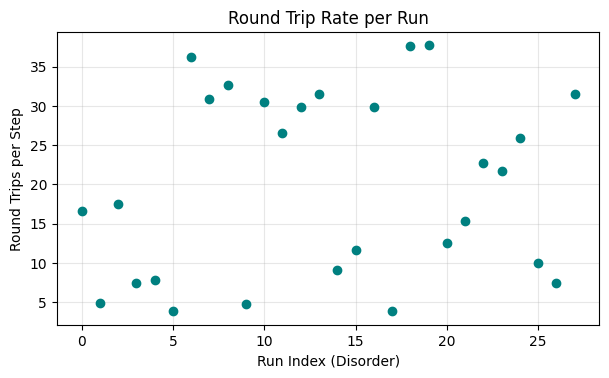

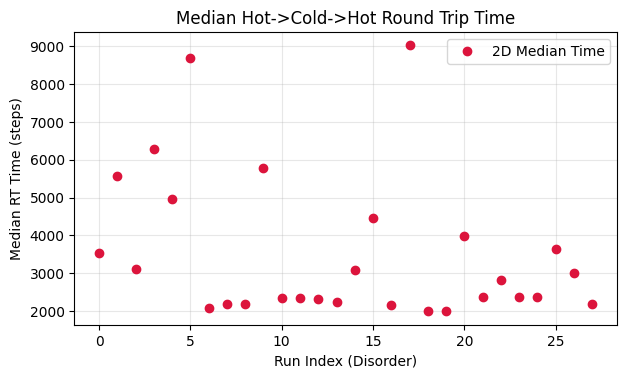

Median Round Trip Rate: 19.6396


: 

In [ ]:
# 1. Prepare Metadata
meta = ptflow.meta_from_sys(sys_2d)

# 2. Extract and Stack Permutations
# We need an array of shape (N_Runs, T_Steps, N_Slots)
# Assuming 'results_2d' is your list of results and each has .I_ts or .Psi_ts
I_list = []
for res in results_2d:
    # get_perm_ts returns (2, T, R), we usually take index 0 (the main chain history)
    # If your results store it differently, just ensure you get shape (T, N_Slots) per run
    I_run = ptflow.get_perm_ts(res)[0] 
    I_list.append(I_run)

I_stack = np.stack(I_list) # Shape: (Runs, Time, Slots)

# 3. Run the Diagnostics
diag_out = pt_diagnostics_report_2d(
    I_stack,
    meta,
    burn_in=0,        # Discard first 10%
    trace_walkers=4,    # Show 4 walker trajectories
    trace_run="median", # Plot the run with median performance
    show=True
)

# 4. Access numerical results if needed
print(f"Median Round Trip Rate: {np.median(diag_out['rt_rates']):.4f}")

In [10]:
def ends_hybrid(meta: ptflow.PTMeta, *, cold_b: int = 0, cold_k_top: int = 1) -> ptflow.Ends:
    """
    HOT: The entire first column (k=0) across ALL rows b. (Any source of randomness).
    COLD: Strictly the physical target (Row cold_b, last cold_k_top nodes).
    """
    R = meta.R
    
    # 1. Identify all nodes where k=0 (The "Hot Column")
    # We iterate through all boxes to find those with k=0
    hot_list = []
    for r in range(R):
        b, k = ptflow.node_to_bk(meta, r)
        if k == 0:
            hot_list.append(r)
    hot_idx = np.array(hot_list, dtype=np.int64)

    # 2. Identify cold nodes strictly in the target row (usually b=0)
    # Get range for row cold_b
    r_start = int(meta.k_start[cold_b])
    r_end   = int(meta.k_start[cold_b + 1])
    K = r_end - r_start
    
    # Take the last 'cold_k_top' nodes in this row
    cold_start_k = max(0, K - cold_k_top)
    cold_idx = np.arange(r_start + cold_start_k, r_end, dtype=np.int64)

    # 3. Validation
    if np.intersect1d(hot_idx, cold_idx).size > 0:
        raise ValueError("Hot and Cold sets overlap!")

    # For plotting convenience, we just define row0_boxes as the target row
    row0 = np.arange(r_start, r_end, dtype=np.int64)

    return ptflow.Ends(hot_idx=hot_idx, cold_idx=cold_idx, b0=cold_b, row0_boxes=row0)

In [9]:
out2 = ptflow.analyze_results_list(
    results_2d, sys_2d,
    b0=0, cold_top=1,
    burn_in=0.0,
    mode="C0_Dual",  b_aux=4, invert=True,
    stride=3,
    average_offsets=True,   # NEW: important
    chunk=4000,
    level="macro"
)
del results_2d
import gc;gc.collect()


49711

In [ ]:

out2s = ptflow.analyze_results_list(
    results_2d, sys_2d,
    b0=0, cold_top=1,
    burn_in=0.0,
    mode="C0_C4",  b_aux=4, invert=False,
    stride=3,
    average_offsets=True,   # NEW: important
    chunk=4000,
    level="macro"
)
out2hi = ptflow.analyze_results_list(
    results_2d, sys_2d,
    b0=0, cold_top=1,
    burn_in=0.0,
    mode="C0_H0",  b_aux=4, invert=True,
    stride=3,
    average_offsets=True,   # NEW: important
    chunk=4000,
    level="macro"
)
out2h = ptflow.analyze_results_list(
    results_2d, sys_2d,
    b0=0, cold_top=1,
    burn_in=0.0,
    mode="C0_H0",  b_aux=4, invert=False,
    stride=3,
    average_offsets=True,   # NEW: important
    chunk=4000,
    level="macro"
)
del results_2d
import gc;gc.collect()

In [12]:
rid = list(out2["per_rid"].keys())[0]
a = out2["per_rid"][rid]
print(a["diag"]["db"])          # DB + stationarity
print("one-way:", a["diag"]["one_way"])


{'n_edges': 1376, 'rel_quantiles': {0.5: 0.16185269980628036, 0.9: 0.45789304578780776, 0.99: 1.0}, 'frac_rel_gt': {0.01: 0.8924418604651163, 0.05: 0.7063953488372093, 0.1: 0.5959302325581395, 0.2: 0.45348837209302323}, 'stat_tv': 3.5561831257524545e-17}
one-way: 0.06395348837209303


--- Rate Comparison ---
Mean Rate 1D: 9.77e-04
Mean Rate 2D: 2.70e-03
Speedup Factor: 2.77x


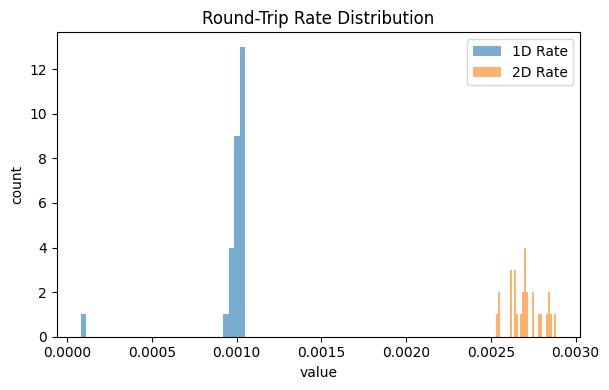

In [13]:
# ==========================================
# 2. GLOBAL METRICS (Did it work?)
# ==========================================

# 1. Rate Speedup
# This is the single most important number.
ptflow.compare_rates(out1['k'], out2s['k'])

# 2. Distribution Comparison
# Visual check that we are not just looking at outliers
ptflow.plot_distribution_compare(out1['k'], out2s['k'], 
                                 label1="1D Rate", label2="2D Rate", 
                                 title="Round-Trip Rate Distribution")

In [14]:
# ==========================================
# 2. GLOBAL METRICS (Did it work?)
# ==========================================

# 1. Rate Speedup
# This is the single most important number.
#ptflow.compare_rates(out1['k'], out2['k'])

# 2. Distribution Comparison
# Visual check that we are not just looking at outliers
#ptflow.plot_distribution_compare(out1['k'], out2['k'], 
#                                 label1="1D Rate", label2="2D Rate", 
#                                 title="Round-Trip Rate Distribution")

In [10]:
def plot_true_effective_connectivity(meta, J_macro, *, min_flux=1e-10, title="True Macro-Connectivity (All Edges)"):
    """
    Plots EVERY edge where J > min_flux, not just nearest neighbors.
    This reveals the 'effective' diagonal jumps made in one stride=3 period.
    """
    B = meta.B
    # Map every node r to coordinates (x, y)
    # x = k, y = b
    coords = {}
    
    # Determine grid size for plot limits
    max_k = 0
    for b in range(B):
        r_start = int(meta.k_start[b])
        r_end = int(meta.k_start[b+1])
        len_k = r_end - r_start
        max_k = max(max_k, len_k)
        for k in range(len_k):
            # coords[node_index] = (x, y)
            # Plotting convention: Row 0 is bottom (y=0)
            coords[r_start + k] = (k, b)

    fig, ax = plt.subplots(figsize=(15, 5 + 2*B))
    
    # 1. Draw Nodes
    for r, (x, y) in coords.items():
        ax.scatter(x, y, c='gray', s=10, alpha=0.3)

    # 2. Draw ALL Significant Edges
    # We iterate over the non-zero elements of J_macro
    # J is typically sparse-ish, so this is efficient enough.
    
    # Get indices where flux is significant
    sources, targets = np.where(np.abs(J_macro) > min_flux)
    
    for u, v in zip(sources, targets):
        # We only plot u -> v (one direction) to avoid double drawing J_net
        # J is skew-symmetric, so we check J[u,v] > 0
        val = J_macro[u, v]
        if val <= min_flux: continue
        
        # Coordinates
        if u not in coords or v not in coords: continue
        x1, y1 = coords[u]
        x2, y2 = coords[v]
        
        # Current Magnitude for width/alpha
        # Normalize roughly for visualization
        width = 0.05 + 6.0 * (abs(val) / np.max(np.abs(J_macro)))
        alpha = 0.6
        
        # Color Logic
        # Blue if same row (Horizontal effective)
        # Orange if adjacent row (Vertical effective)
        # Green if "Knight's Move" (Diagonal / Multi-row jump)
        if y1 == y2:
            color = 'C0' # Horizontal
        elif abs(y1 - y2) == 1 and x1 == x2:
            color = 'C1' # Pure Vertical
        else:
            color = 'C2' # Diagonal / Complex
            
        # Draw Arrow
        ax.arrow(x1, y1, x2-x1, y2-y1, 
                 head_width=0.05, head_length=0.25, 
                 fc=color, ec=color, 
                 width=0.01 * width, 
                 length_includes_head=True, alpha=alpha)

    ax.set_title(title)
    ax.set_xlabel("Temperature Index k")
    ax.set_ylabel("Row Index b")
    # Legend for edge types
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='C0', lw=2),
                    Line2D([0], [0], color='C1', lw=2),
                    Line2D([0], [0], color='C2', lw=2)]
    ax.legend(custom_lines, ['Intra-Row', 'Vertical', 'Diagonal/Effective'])
    
    plt.tight_layout()
    plt.show()

In [16]:
def print_flux_balance(meta, J):
    """
    Summarizes the net reactive flux direction for each row.
    """
    print(f"{'Row':<5} | {'Net Vertical (Down)':<20} | {'Net Horizontal (Right)':<20} | {'Dominant Flow'}")
    print("-" * 70)
    
    for b in range(meta.B):
        # Identify nodes in this row
        r_start = int(meta.k_start[b])
        r_end   = int(meta.k_start[b+1])
        nodes = np.arange(r_start, r_end)
        
        # 1. Vertical Flow (out of this row, towards b-1)
        # We sum J[u, v] where u in Row b, v in Row b-1
        flux_down = 0.0
        if b > 0:
            prev_start = int(meta.k_start[b-1])
            prev_end   = int(meta.k_start[b])
            # This slicing assumes reasonable adjacency, but generally:
            # We look at J[nodes, prev_nodes]
            # Slicing J is expensive if dense, but J is usually sparse.
            # Let's iterate edges for safety or use smart slicing if J is numpy array
            
            # Fast approximation: Sum of J[u, v] for all u in row, v < r_start
            # (Assuming lower indices are lower rows)
            flux_down = np.sum(J[r_start:r_end, :r_start])
            
        # 2. Horizontal Flow (within this row, towards higher k)
        # Sum of J[k, k+1] inside the row
        flux_right = 0.0
        for k in range(r_start, r_end - 1):
             flux_right += J[k, k+1]
             
        # Normalize for display (relative to max flux in system)
        total_mag = abs(flux_down) + abs(flux_right) + 1e-12
        
        # Determine label
        if b == 4:
            label = "SOURCE (Ideally 0 flux in)"
        elif b == 0:
            label = "SINK (Accumulates)"
        elif abs(flux_down) > 2 * abs(flux_right):
            label = "raining DOWN"
        elif abs(flux_right) > 2 * abs(flux_down):
            label = "Moving RIGHT"
        else:
            label = "Mixed / Diagonal"
            
        print(f"{b:<5} | {flux_down:10.2e}           | {flux_right:10.2e}           | {label}")

# Run it
print_flux_balance(out2s['meta'], out2s['per_rid'][3]['J'])

Row   | Net Vertical (Down)  | Net Horizontal (Right) | Dominant Flow
----------------------------------------------------------------------
0     |   0.00e+00           |   1.22e-03           | SINK (Accumulates)
1     |   2.71e-03           |   3.71e-04           | raining DOWN
2     |   2.71e-03           |   4.97e-04           | raining DOWN
3     |   2.71e-03           |   8.26e-05           | raining DOWN
4     |   2.72e-03           |   0.00e+00           | SOURCE (Ideally 0 flux in)


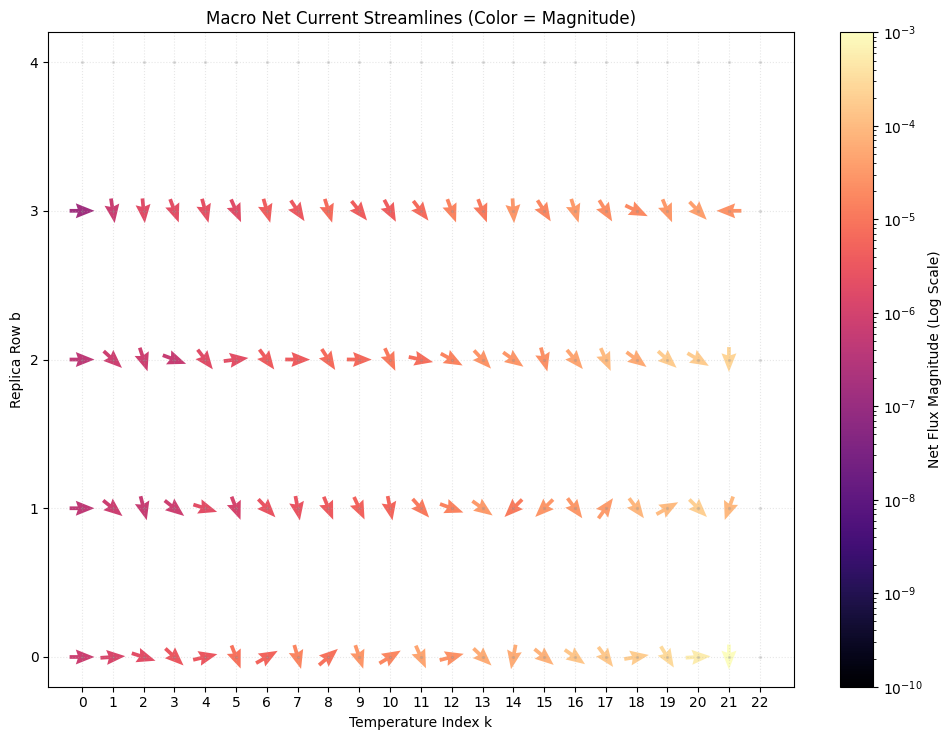

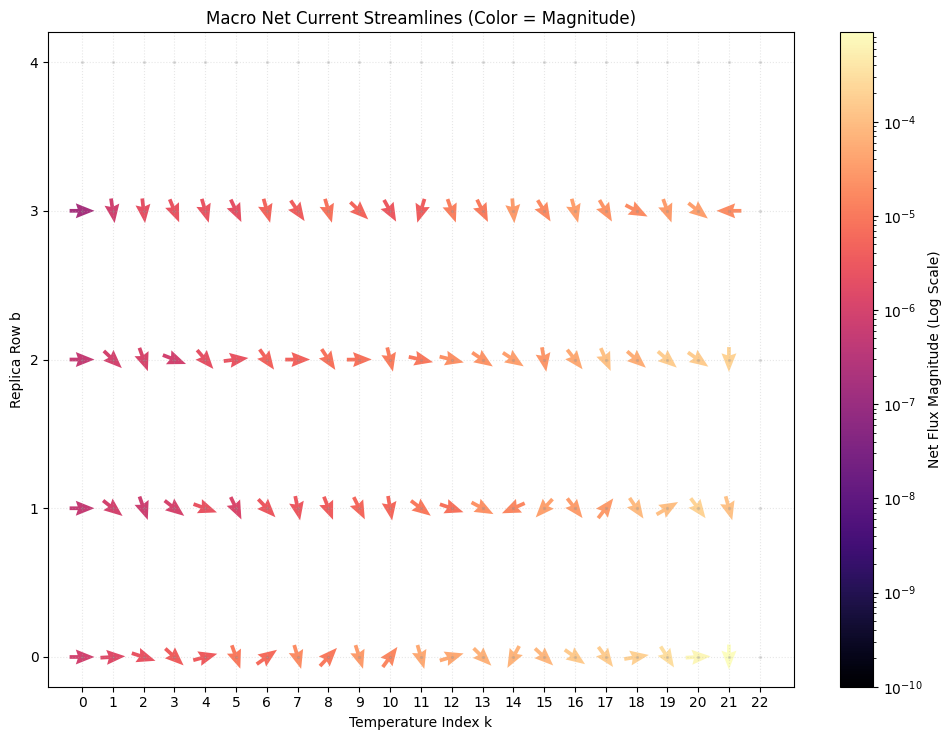

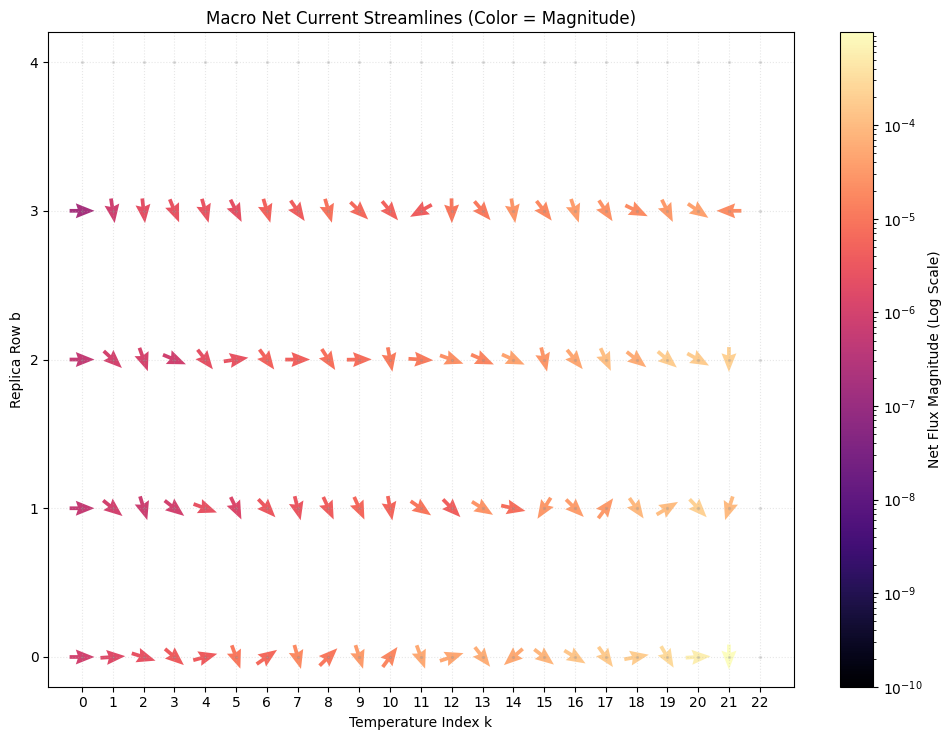

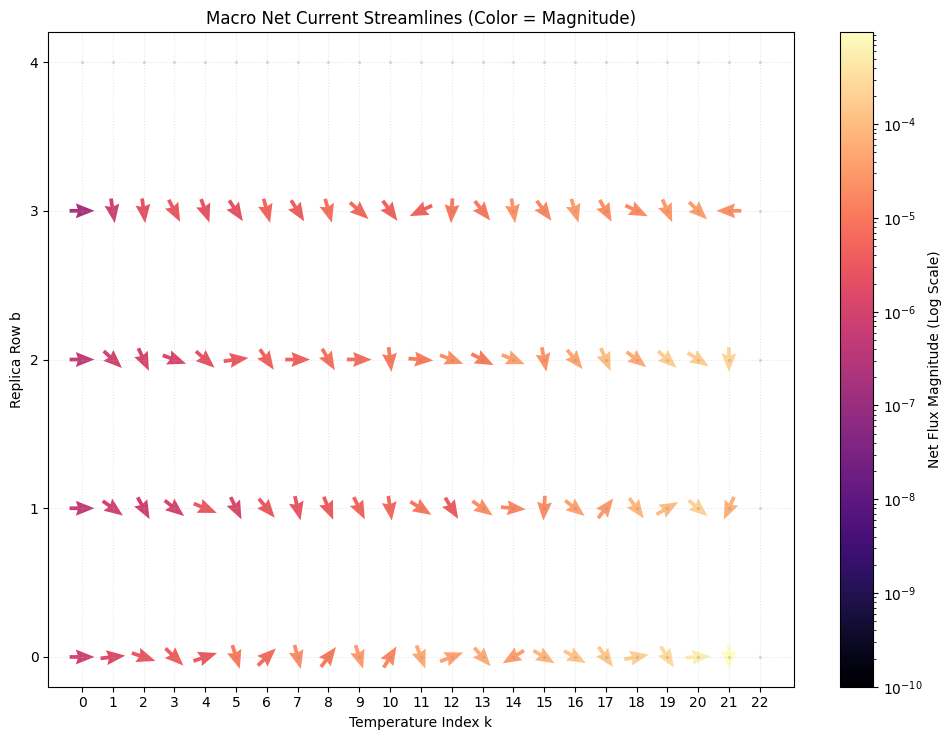

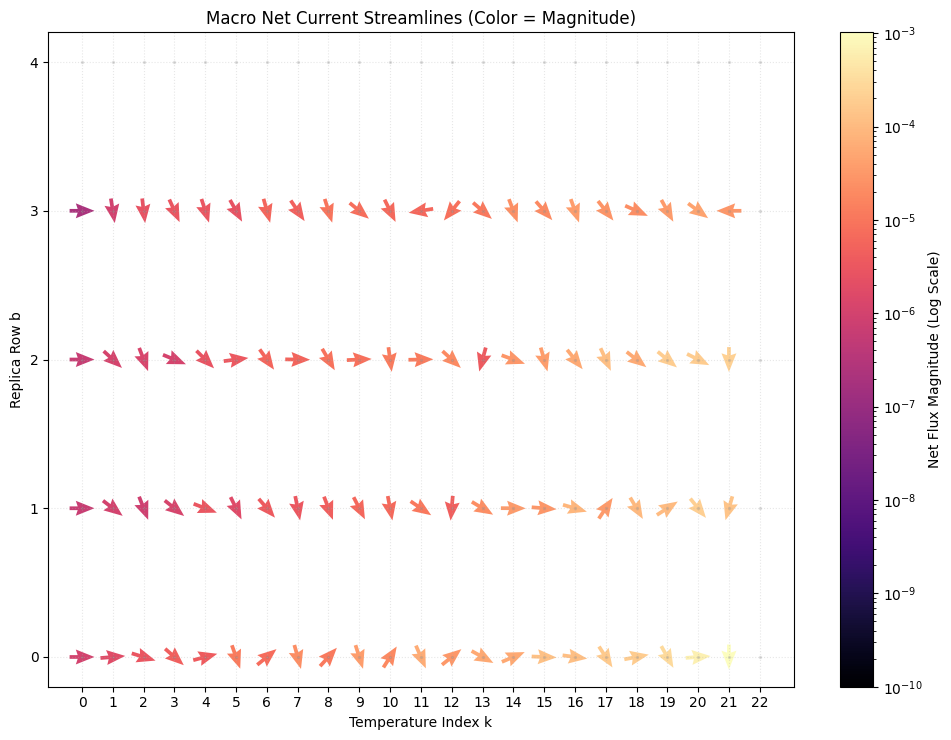

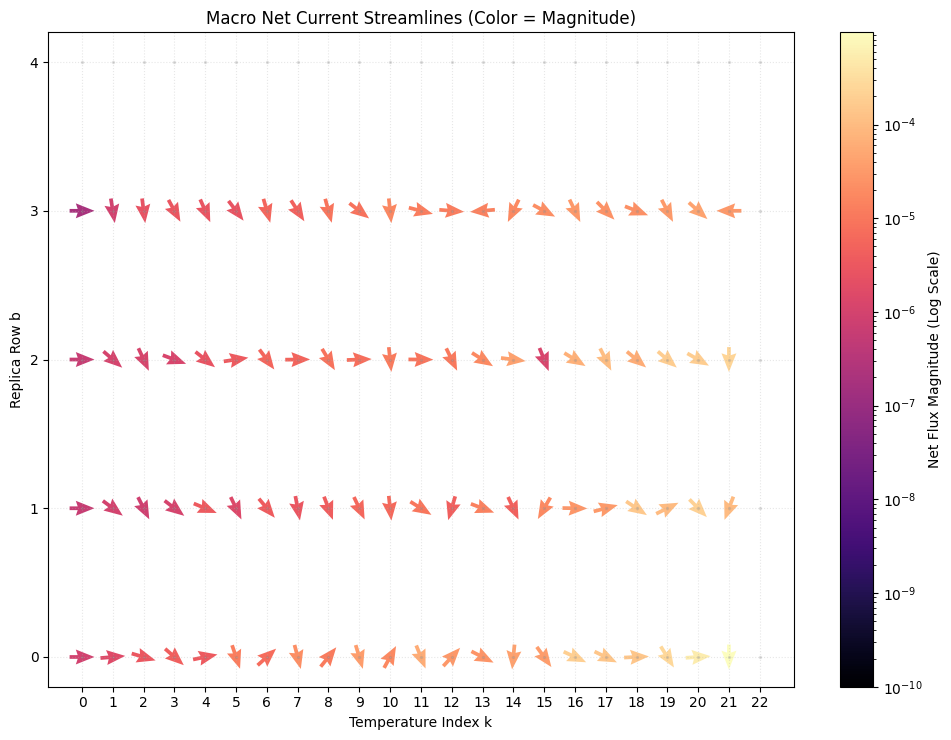

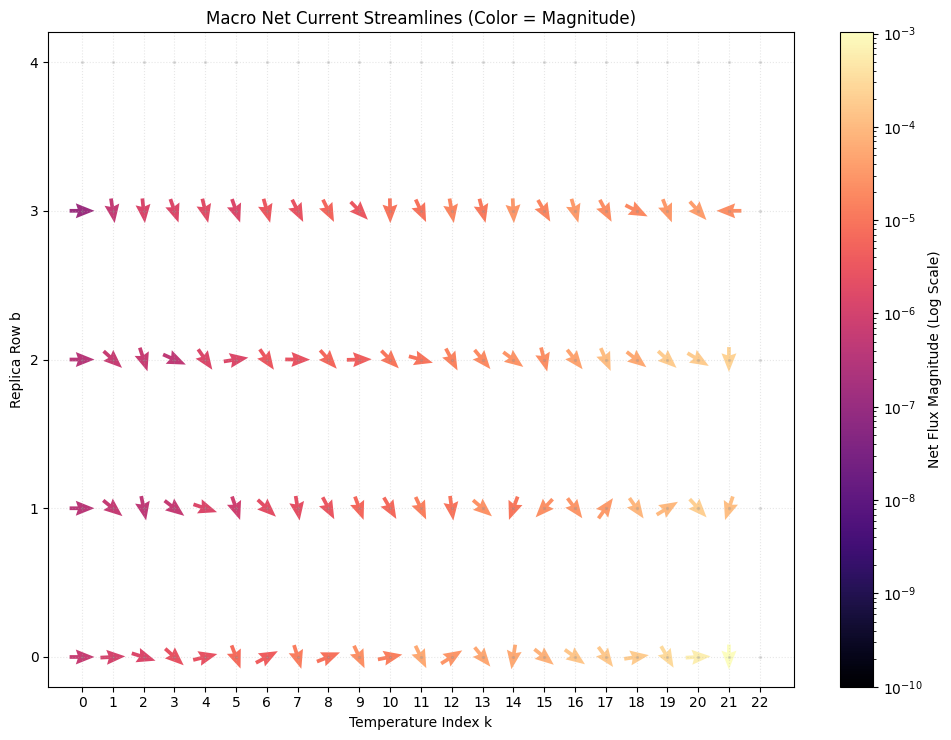

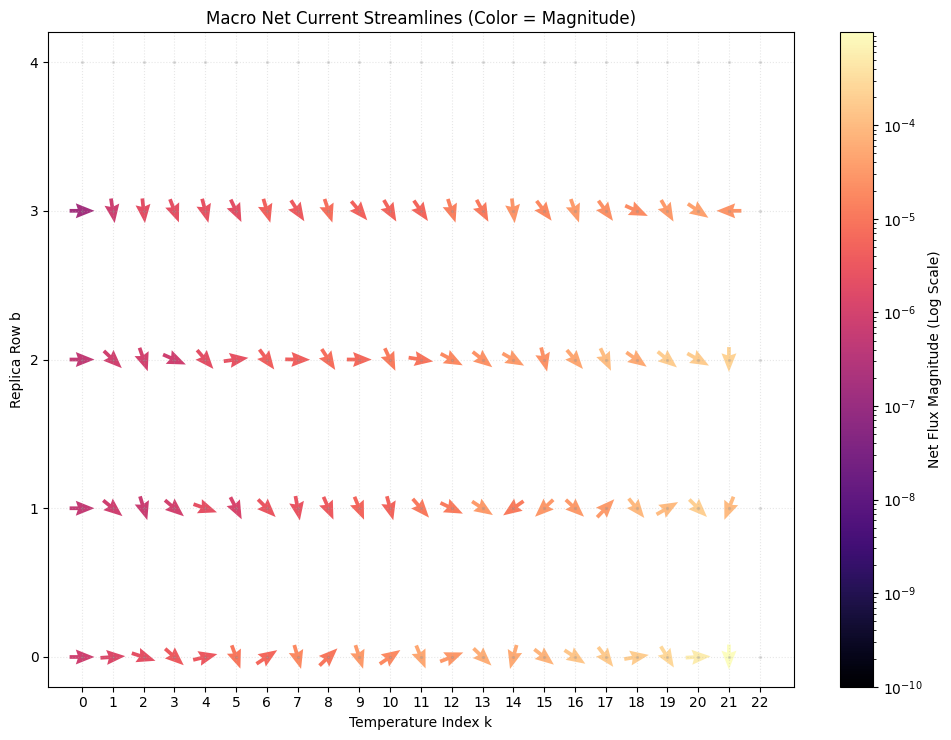

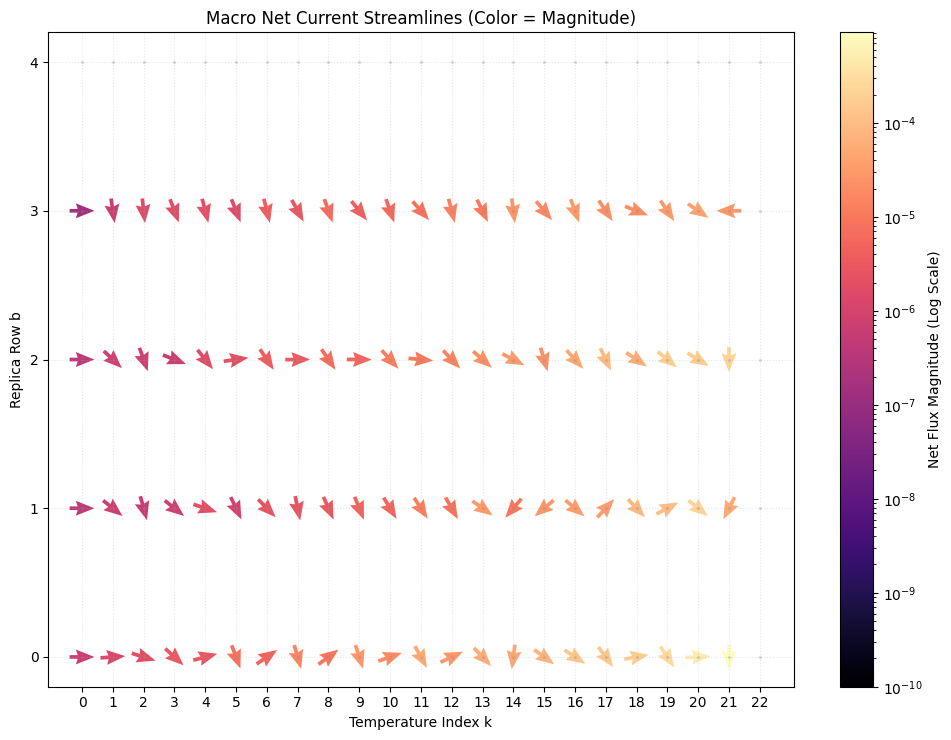

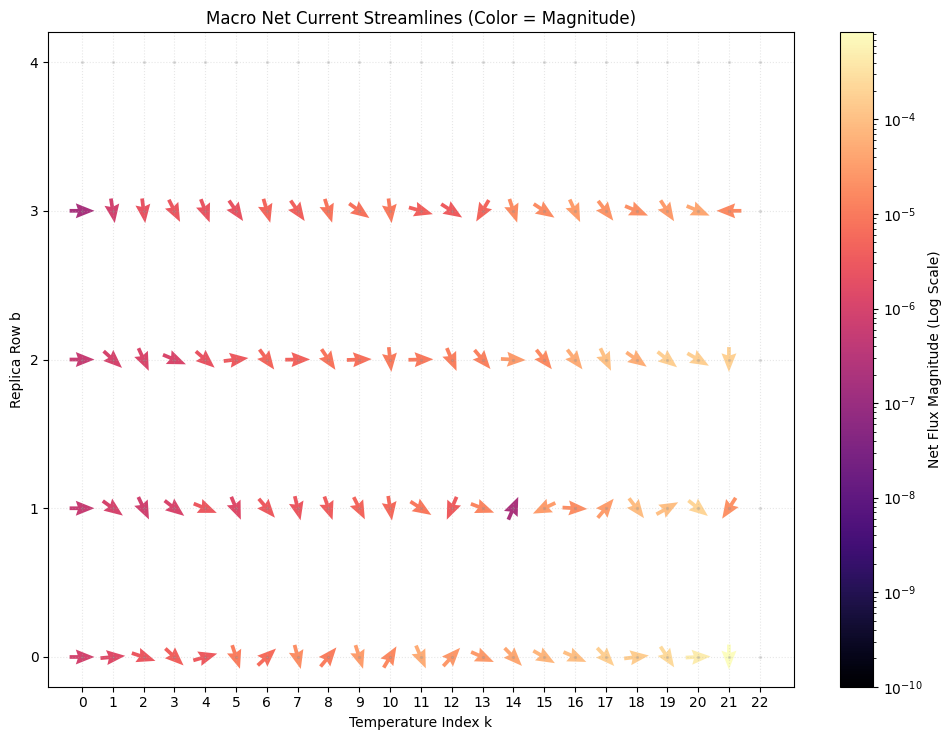

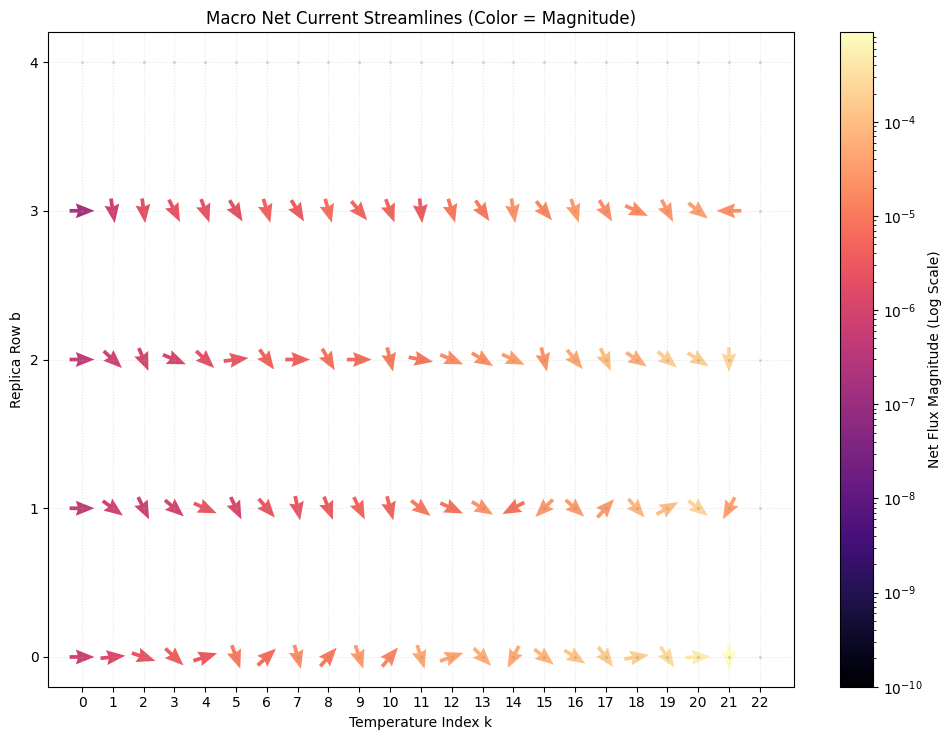

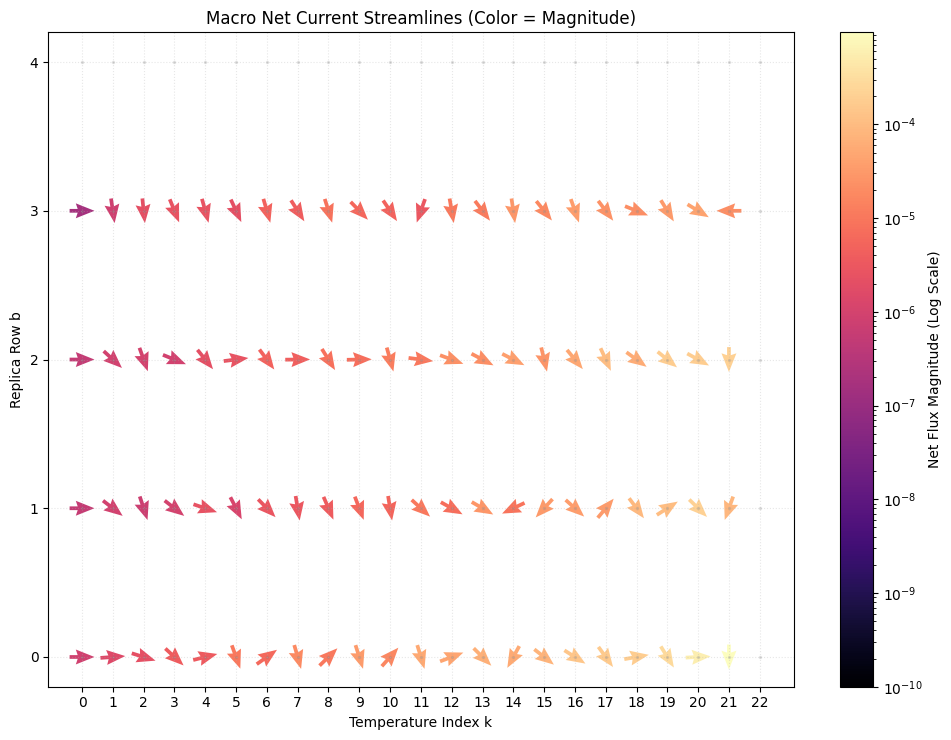

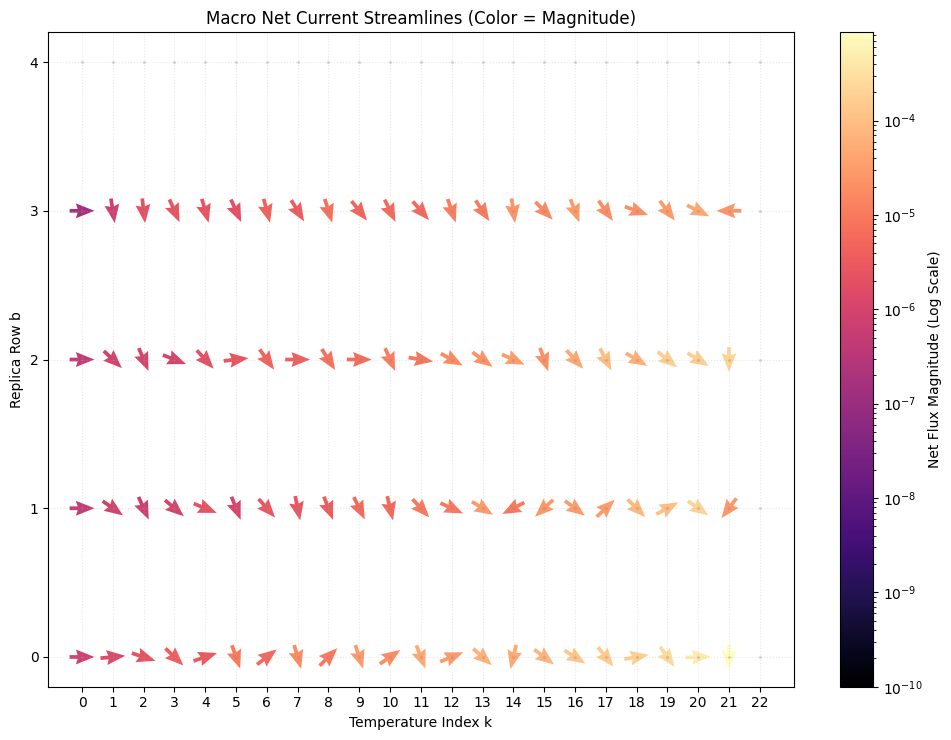

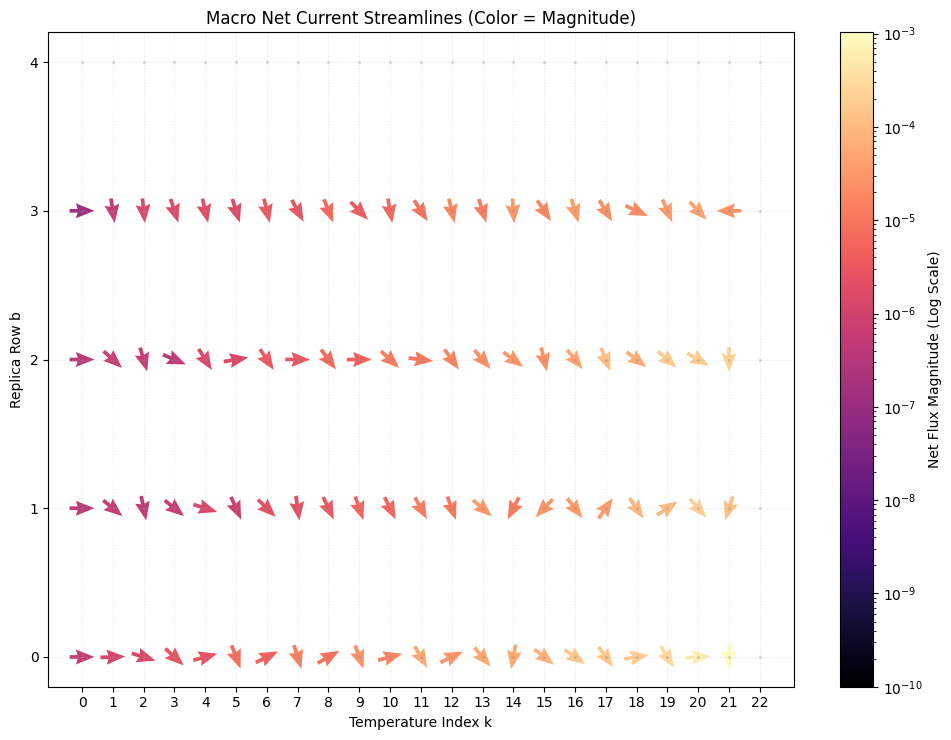

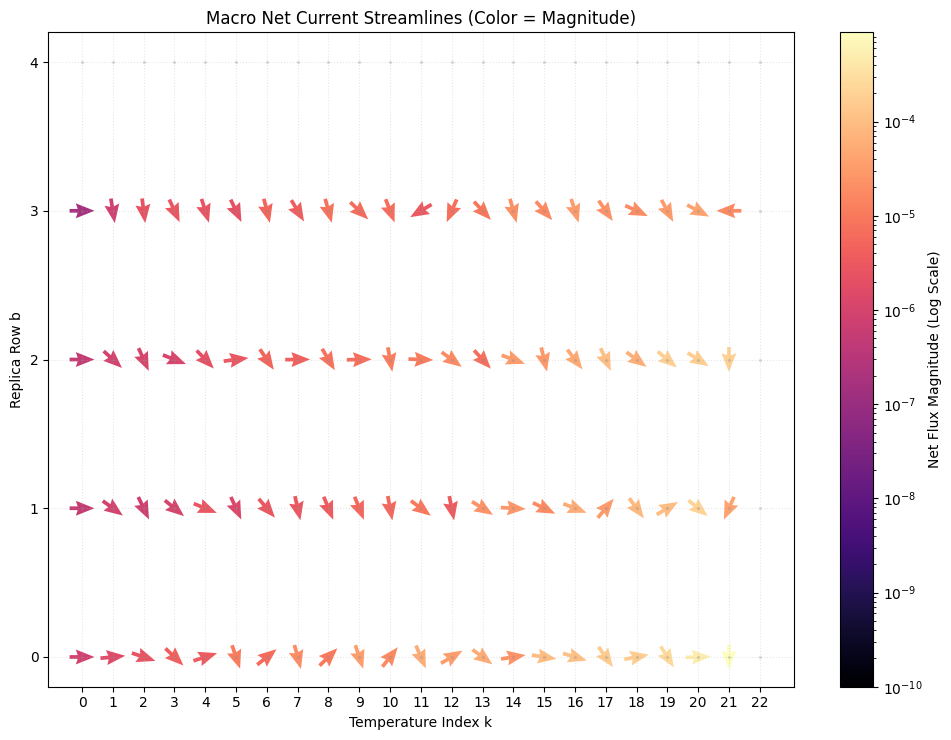

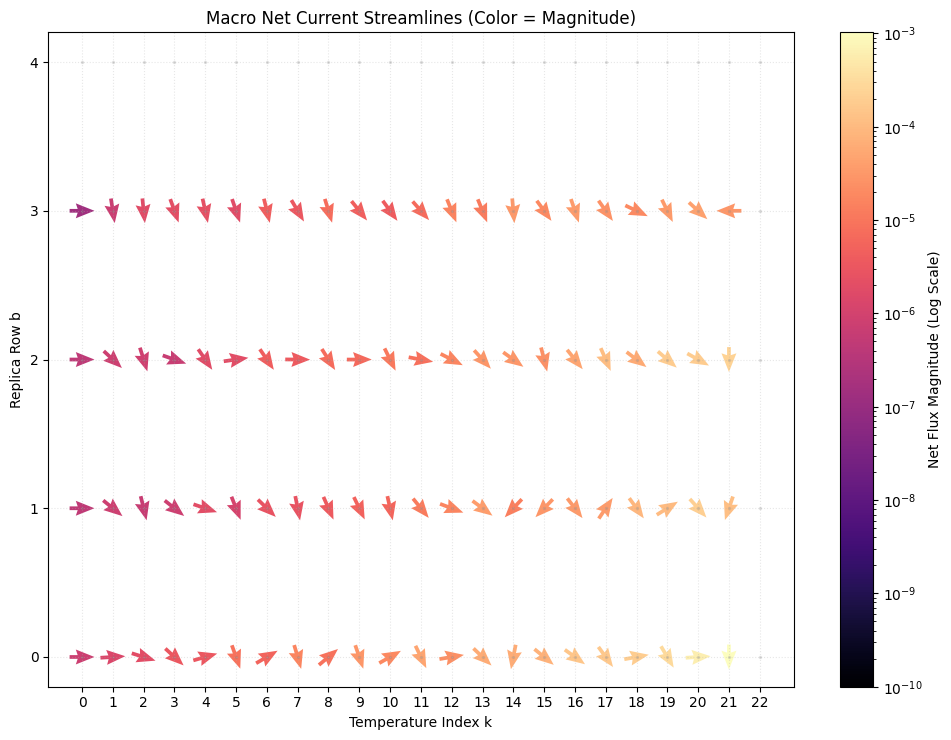

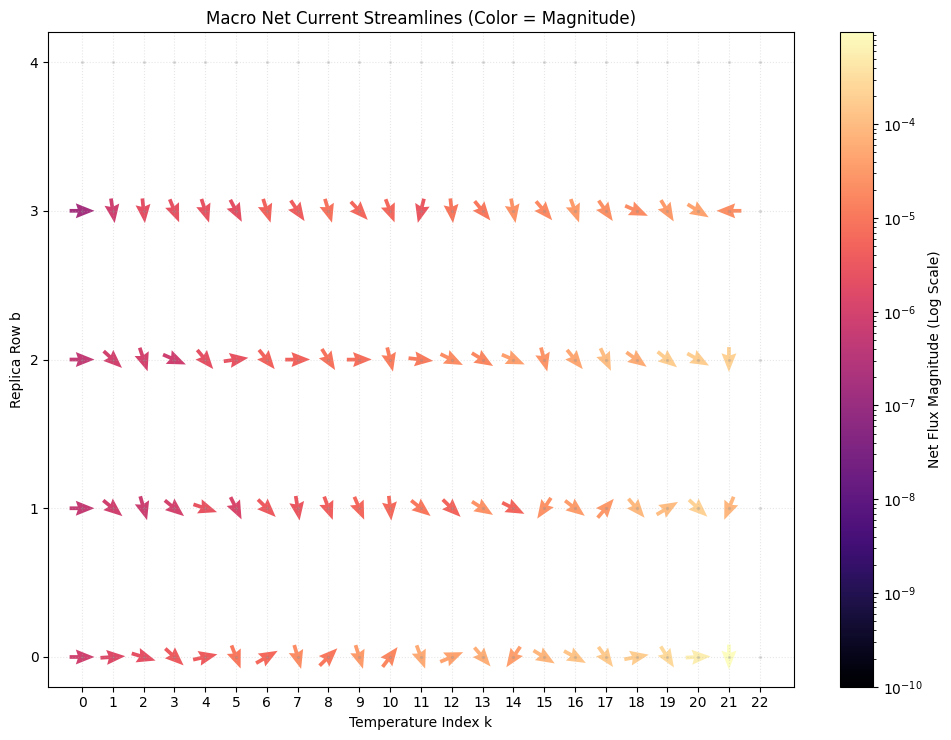

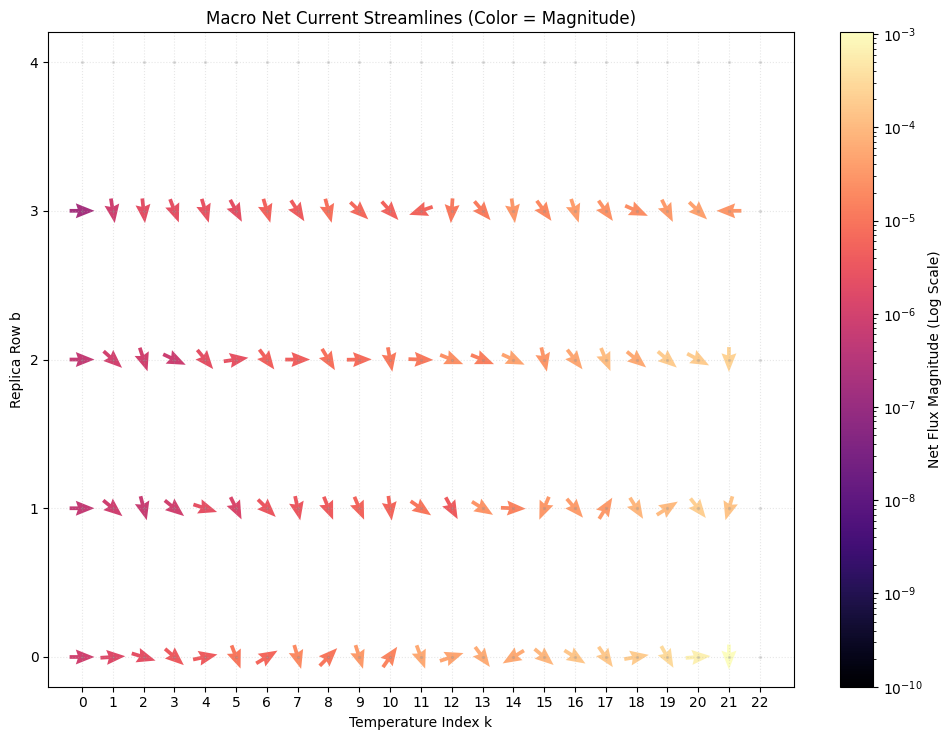

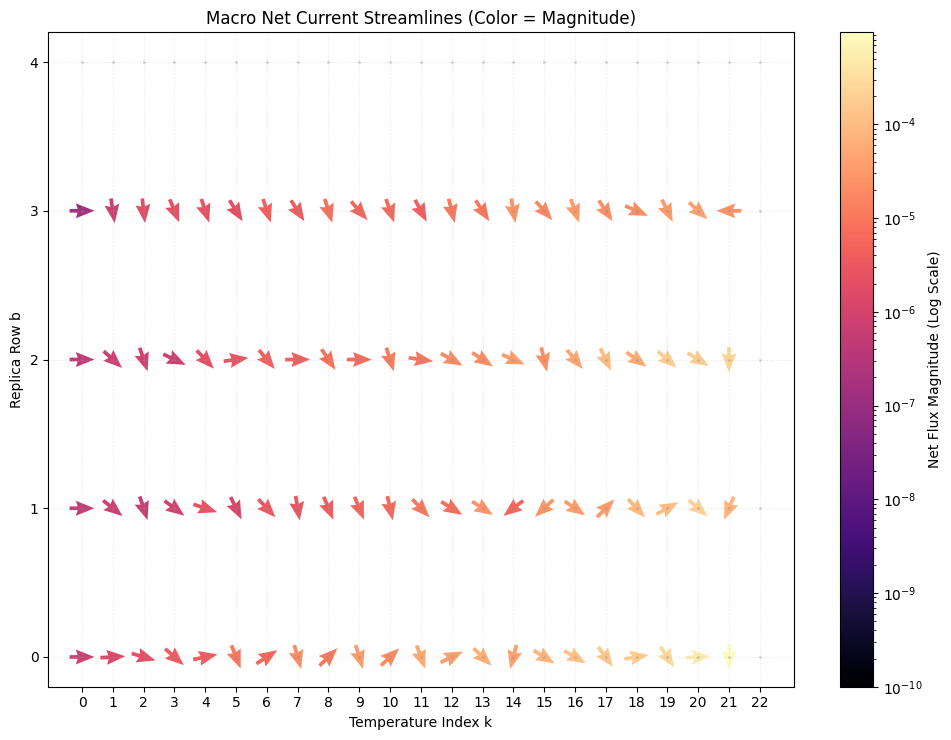

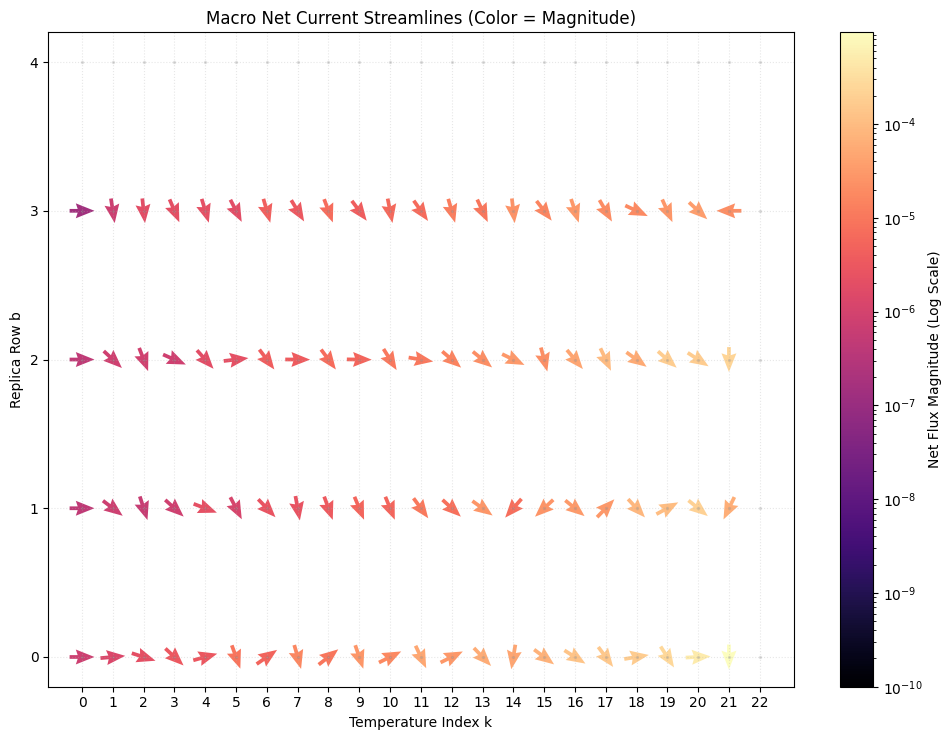

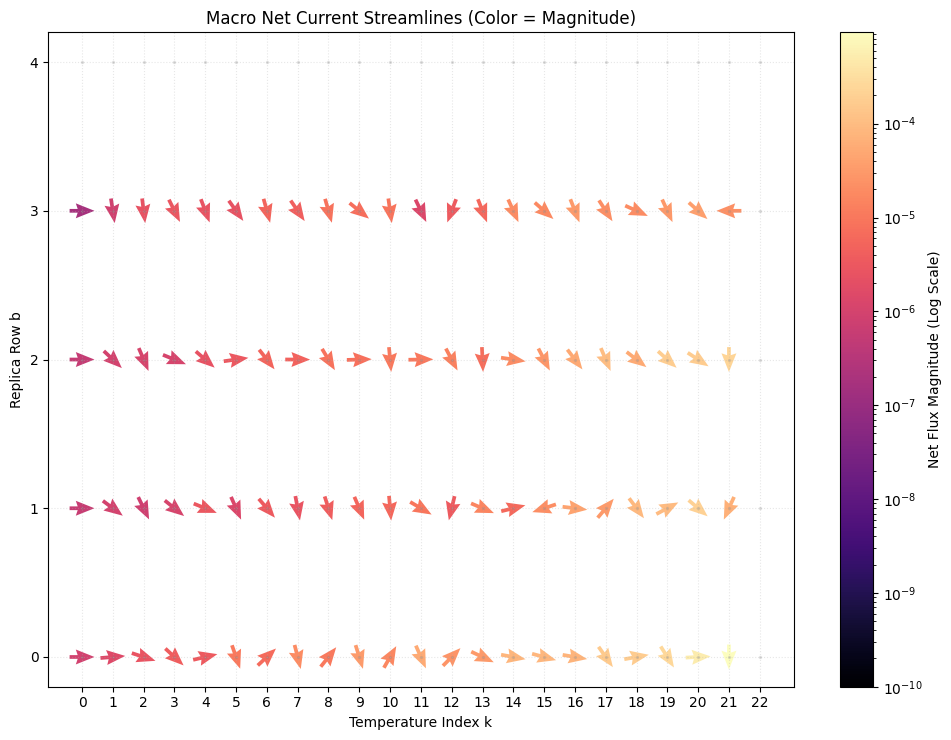

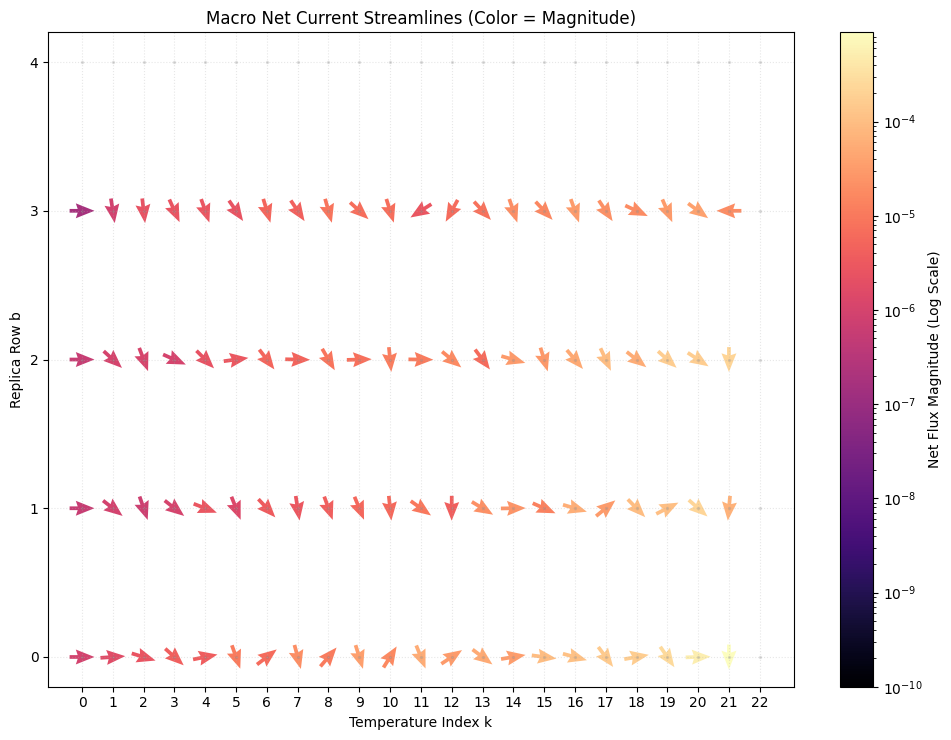

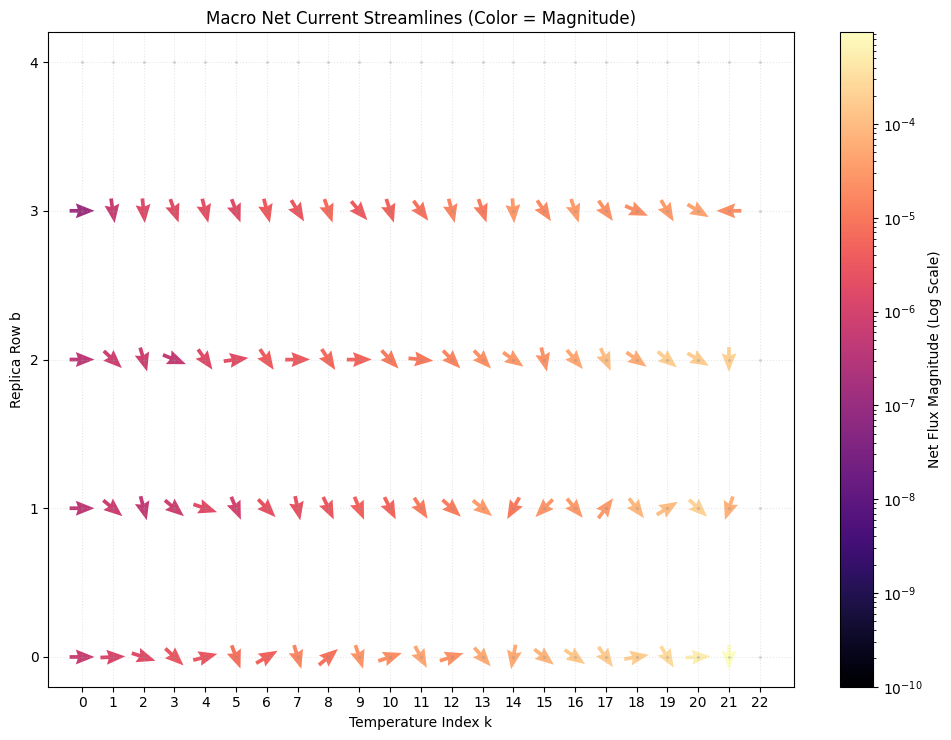

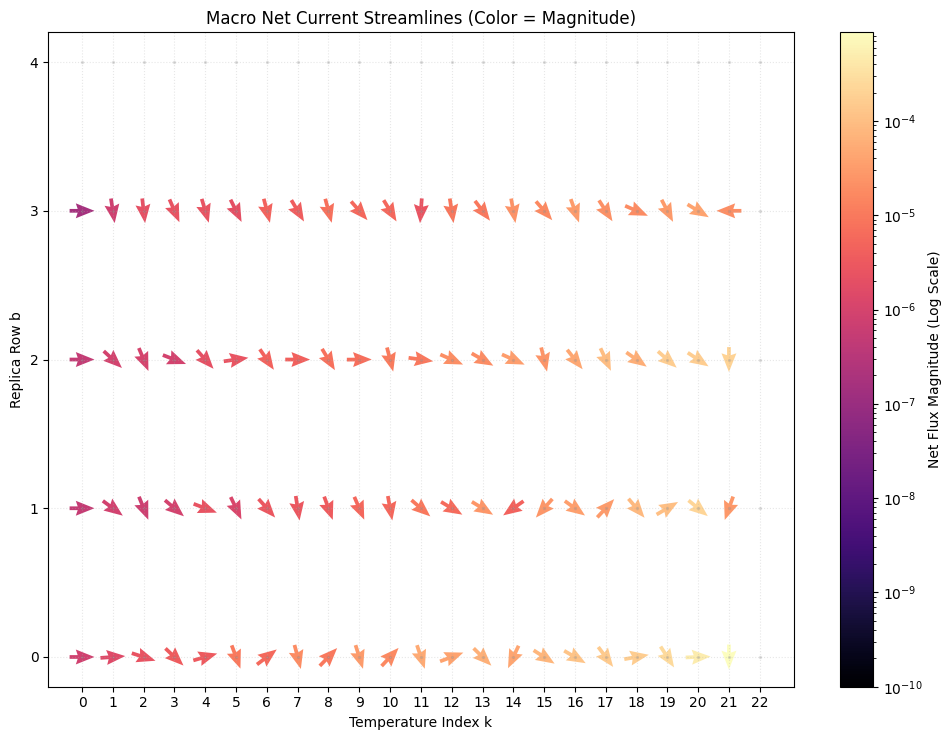

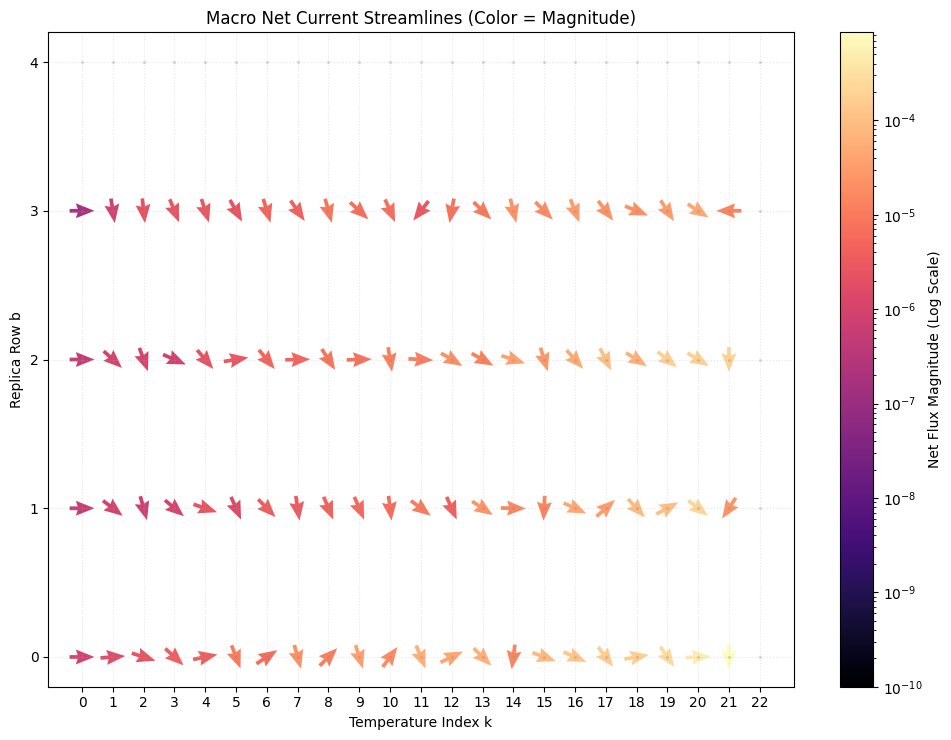

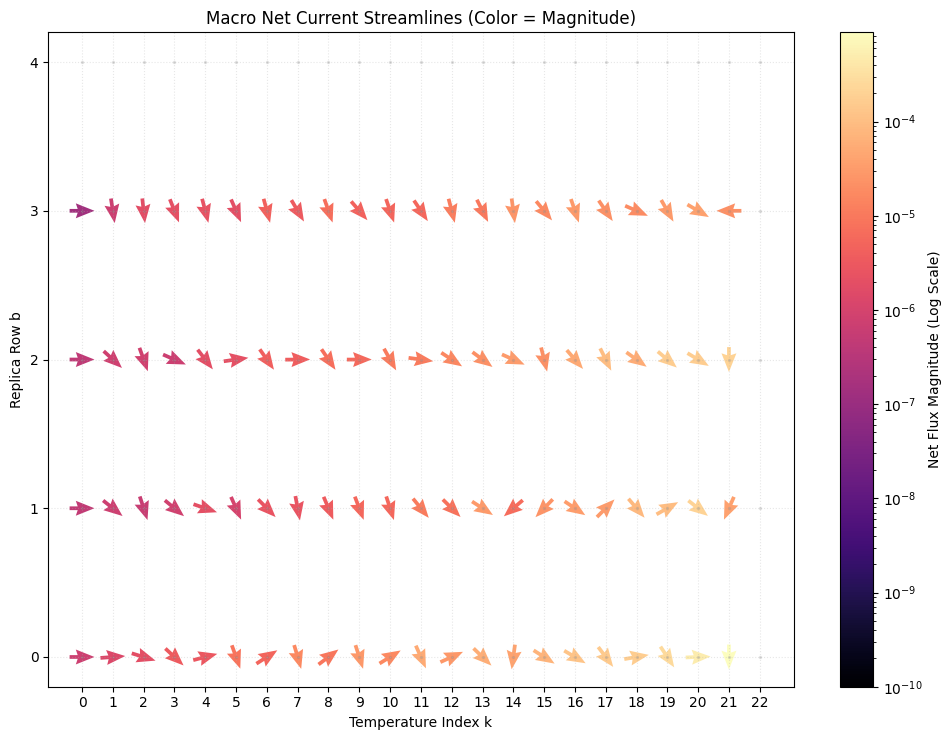

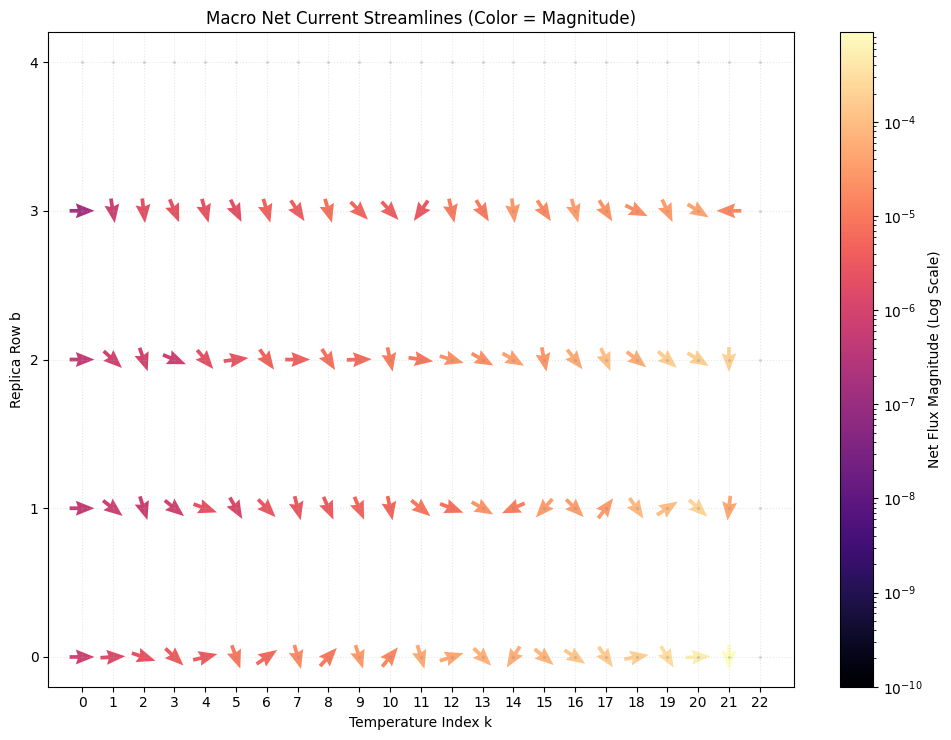

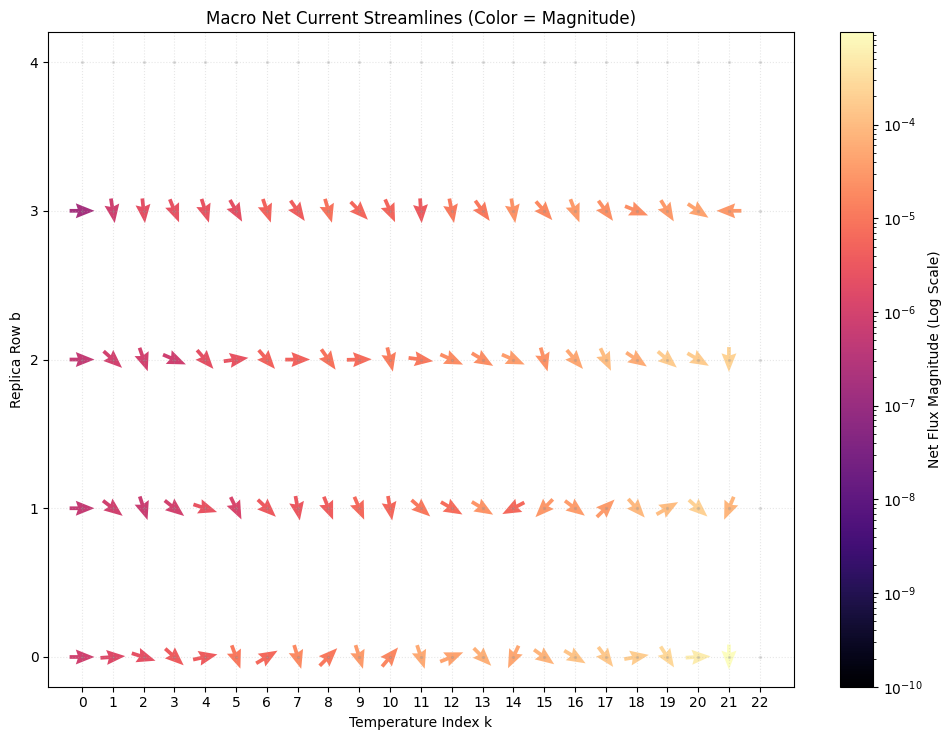

In [17]:
meta = out2['meta'] 
for rid in range(28):
    J_macro = out2['per_rid'][rid]['J'] 

    # A. The Highway Plot (Streamlines)
    ptflow.plot_2d_current_streamlines(meta, J_macro)

In [59]:
def plot_2d_current_streamlines(
    meta: PTMeta, 
    J_macro: np.ndarray, 
    *, 
    title: str = "Net Current Streamlines",
    min_flux: float = 1e-10,
    cmap_name: str = 'magma_r',
    transpose_axes: bool = True  # <--- NEW SWITCH
):
    """
    Visualizes the "Net Current" J as a 2D vector field.
    transpose_axes=False: X=Temp(k), Y=Replica(b) (Standard)
    transpose_axes=True:  X=Replica(b), Y=Temp(k) (Portrait Mode)
    """
    B = meta.B
    
    # 1. Determine Grid Dimensions
    max_k = 0
    node_coords = {} 

    for b in range(B):
        r_start = int(meta.k_start[b])
        r_end = int(meta.k_start[b+1])
        len_k = r_end - r_start
        max_k = max(max_k, len_k)

    for b in range(B):
        r_start = int(meta.k_start[b])
        r_end = int(meta.k_start[b+1])
        len_k = r_end - r_start
        
        for k_idx in range(len_k):
            u = r_start + k_idx

            d= max_k-len_k

            if (d>0 and k_idx>2): 
                node_coords[u] = (k_idx+d, b)
            else:
                node_coords[u] = (k_idx, b)

    # 2. Calculate Physical Vectors (Flux in k, Flux in b)
    # U_phys = Flux along k (Horizontal in standard plot)
    # V_phys = Flux along b (Vertical in standard plot)
    U_phys = np.zeros((B, max_k)) 
    V_phys = np.zeros((B, max_k))
    
    for u, (kx_u, ky_u) in node_coords.items():
        vec_k = 0.0 # Physical k-flux
        vec_b = 0.0 # Physical b-flux
        
        targets = np.where(np.abs(J_macro[u]) > 0)[0]
        
        for v in targets:
            flux = J_macro[u, v]
            if v not in node_coords: continue
            
            kx_v, ky_v = node_coords[v]
            dk = kx_v - kx_u
            db = ky_v - ky_u
            
            vec_k += flux * dk
            vec_b += flux * db
            
        U_phys[ky_u, kx_u] = vec_k
        V_phys[ky_u, kx_u] = vec_b

    # 3. Handle Axis Transposition
    if transpose_axes:
        # X-axis = Replica (b) [Size B]
        # Y-axis = Temp (k)    [Size max_k]
        X = np.arange(B)
        Y = np.arange(max_k)
        
        # Transpose matrices so shape matches (Y, X) -> (max_k, B)
        # And SWAP vector components:
        # Screen Horizontal (U) comes from Physical b-flux (V_phys)
        # Screen Vertical (V) comes from Physical k-flux (U_phys)
        U_plot = V_phys.T
        V_plot = U_phys.T
        
        xlabel = "Replica Row b"
        ylabel = "Temperature Index k"
        
    else:
        # Standard Landscape
        # X-axis = Temp (k)
        # Y-axis = Replica (b)
        X = np.arange(max_k)
        Y = np.arange(B)
        
        U_plot = U_phys
        V_plot = V_phys
        
        xlabel = "Temperature Index k"
        ylabel = "Replica Row b"

    MAG = np.sqrt(U_plot**2 + V_plot**2)
    mask = MAG > min_flux
    
    # A. Calculate Unit Directions
    # (Avoid divide by zero warnings using the mask)
    U_unit = np.zeros_like(U_plot)
    V_unit = np.zeros_like(V_plot)
    
    U_unit[mask] = U_plot[mask] / MAG[mask]
    V_unit[mask] = V_plot[mask] / MAG[mask]
    
    # B. Define "Display Length"
    # We compress the range. Instead of Length = Magnitude, 
    # we use Length = Magnitude^alpha.
    # alpha=0.3 is usually the "magic number" for high dynamic range flows.
    # It allows you to see 1e-6 and 1e-2 on the same plot.
    length_power = 0.3  
    
    # Normalize MAG to 0..1 range first for stable scaling
    max_mag = np.nanmax(MAG)
    if max_mag == 0: max_mag = 1.0
    
    # This creates lengths between 0.0 and 1.0, heavily boosting small values
    LEN_display = (MAG / max_mag) ** length_power
    
    # C. Reconstruct "Visual" Vectors
    # These vectors have "fake" lengths for display, but correct directions
    U_visual = U_unit * LEN_display
    V_visual = V_unit * LEN_display
    
    # Apply Mask
    U_visual[~mask] = np.nan
    V_visual[~mask] = np.nan

    # 5. Plotting
    # -------------------------------------------------
    if transpose_axes:
        fig_w, fig_h = 5 + 0.6*B, 8 
    else:
        fig_w, fig_h = 10, 5 + 0.5*B

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    
    norm = mcolors.PowerNorm(vmin=max(min_flux, MAG[mask].min()), vmax=max_mag, gamma=1)
    
    q = ax.quiver(X, Y, U_visual, V_visual, MAG, 
                  cmap=cmap_name, norm=norm,
                  pivot='mid',
                  
                  # --- THE FIX ---
                  angles='uv',          # Arrow direction is relative to Screen Pixels (not Data Grid)
                  scale_units='width',  # Arrow length is relative to Plot Width
                  scale=7,             # Inverse Scale: Higher number = Shorter arrows. Tune this!
                  
                  headwidth=4, headlength=5, width=0.005)

    cbar = plt.colorbar(q, ax=ax)
    scale_label = f" (x{flux_scale_factor:g})" if 'flux_scale_factor' in locals() and flux_scale_factor != 1 else ""
    cbar.set_label(f'Net Flux Magnitude{scale_label}')
    
    ax.set_xticks(X)
    ax.set_yticks(Y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle=':', alpha=0.3)
    ax.scatter(np.tile(X, len(Y)), np.repeat(Y, len(X)), c='gray', s=2, alpha=0.6)
    plt.xlim()
    
    plt.tight_layout()
    plt.show()

In [20]:
np.diff(meta.k_start)

array([22, 23, 22, 23, 21])

Visualizing representative Run ID: 18


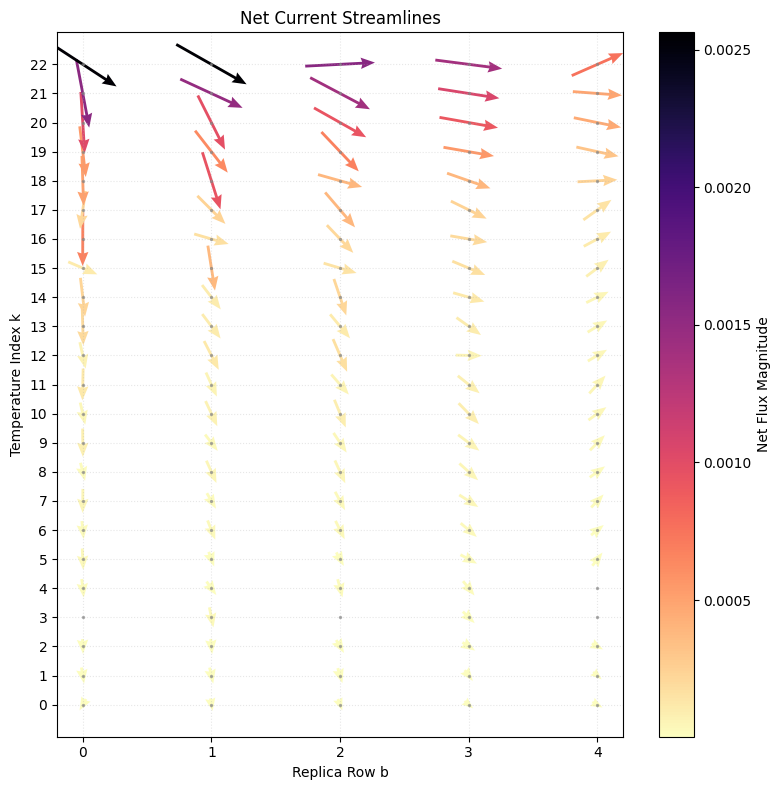

In [60]:
# Pick a representative run
rid = int(out2['rid'][np.argsort(out2['k'])[len(out2['k'])//2]])
print(f"Visualizing representative Run ID: {rid}")

# CORRECTION HERE: meta is at the top level
meta = out2['meta'] 
# J is specific to the run
J_macro = out2['per_rid'][rid]['J'] 

import matplotlib.colors as mcolors
# A. The Highway Plot (Streamlines)
plot_2d_current_streamlines(meta, J_macro)

Visualizing representative Run ID: 27


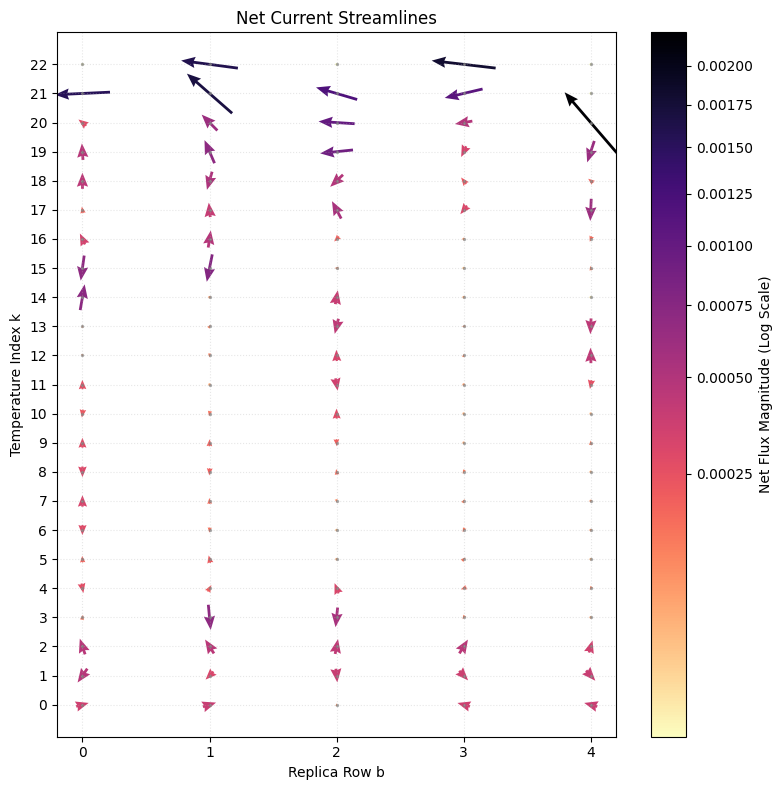

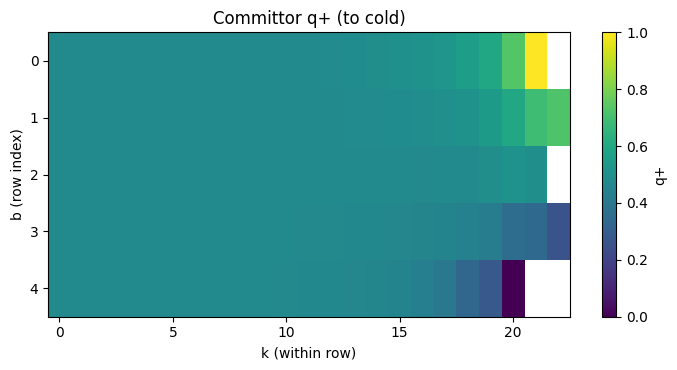

In [12]:
# ==========================================
# 3. MECHANISM (How did it work?)
# ==========================================

# Pick a representative run
rid = int(out2s['rid'][np.argsort(out2s['k'])[len(out2s['k'])//2]])
print(f"Visualizing representative Run ID: {rid}")

# CORRECTION HERE: meta is at the top level
meta = out2s['meta'] 
# J is specific to the run
J_macro = out2s['per_rid'][rid]['J'] 

import matplotlib.colors as mcolors
# A. The Highway Plot (Streamlines)
plot_2d_current_streamlines(meta, J_macro)

# B. Committor Map
ptflow.plot_committor(meta, out2s['per_rid'][rid]['q_plus'])

# C. Micro Vertical Flux
# Note: Ensure you use the 'meta' from the micro result if the systems differed, 
# but usually they are the same.
#f_lifted = out2_micro['per_rid'][rid]['f_lifted']
#ptflow.plot_micro_vertical_flux(meta, f_lifted, period=3)

In [ ]:
plot_true_effective_connectivity(meta, J_macro, title="Macro-Connectivity",min_flux=1-3)

KeyboardInterrupt: 

/home/blazek_137/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/blazek_137/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
def rt_median_HCH_1d(I2, *, hot_k=0, cold_top=1, burn_in=0.1, stride=1):
    """
    I2: (2, T, R) box->label permutations.
    Defines:
      H = box hot_k
      C = top 'cold_top' boxes (largest index)
    Returns:
      rt_med (float), rt_cnt (int), rt_all (np.ndarray)
    Times are in "tick" units of your saved permutation series.
    """
    I2 = np.asarray(I2, dtype=np.int64)
    assert I2.ndim == 3 and I2.shape[0] == 2
    _, T, R = I2.shape

    hot_idx = np.array([int(hot_k)], dtype=np.int64)
    cold_top = int(max(1, cold_top))
    cold_idx = np.arange(max(0, R - cold_top), R, dtype=np.int64)

    # burn + stride
    t0 = int(np.floor(burn_in * T)) if isinstance(burn_in, float) else int(burn_in)
    t0 = max(0, min(t0, T-1))
    stride = int(max(1, stride))
    idxs = np.arange(t0, T, stride, dtype=np.int64)

    rts = []

    for c in (0, 1):
        I = I2[c]  # (T,R)
        hot_start = np.full(R, -1, dtype=np.int64)
        seen_cold = np.zeros(R, dtype=bool)

        for tt in idxs:
            It = I[tt]

            # labels currently in hot/cold boxes
            wH = It[hot_idx]     # (1,)
            wC = It[cold_idx]    # (cold_top,)

            # mark cold seen since last hot
            for w in np.ravel(wC):
                w = int(w)
                if hot_start[w] != -1:
                    seen_cold[w] = True

            # close round trip on hot hit
            for w in np.ravel(wH):
                w = int(w)
                if hot_start[w] != -1 and seen_cold[w]:
                    rts.append(tt - hot_start[w])
                hot_start[w] = tt
                seen_cold[w] = False

    rts = np.asarray(rts, dtype=np.int64)
    rt_med = float(np.median(rts)) if rts.size else np.nan
    return rt_med, int(rts.size), rts


In [13]:
'''
Nd = 28

rt_med = np.empty(Nd, dtype=np.float64)
rt_cnt = np.empty(Nd, dtype=np.int64)

for rid in range(Nd):
    m, c, _ = rt_median_HCH_1d(I_ts_t0_stack[rid], hot_k=0, cold_top=1, burn_in=0.0, stride=1)
    rt_med[rid] = m
    rt_cnt[rid] = c

# worst = largest median RT
mask = np.isfinite(rt_med) & (rt_cnt > 0)
order = np.argsort(rt_med[mask])[::-1]

worst_rids = np.arange(Nd, dtype=int)[mask][order][:5]
worst_med  = rt_med[mask][order][:5]
worst_cnt  = rt_cnt[mask][order][:5]

print("Top 5 worst rids by largest median H->C->H (ticks):")
for r, m, c in zip(worst_rids, worst_med, worst_cnt):
    print(f"rid={r:3d}  median_RT={m:8.1f}  count={c}")
'''

'\nNd = 28\n\nrt_med = np.empty(Nd, dtype=np.float64)\nrt_cnt = np.empty(Nd, dtype=np.int64)\n\nfor rid in range(Nd):\n    m, c, _ = rt_median_HCH_1d(I_ts_t0_stack[rid], hot_k=0, cold_top=1, burn_in=0.0, stride=1)\n    rt_med[rid] = m\n    rt_cnt[rid] = c\n\n# worst = largest median RT\nmask = np.isfinite(rt_med) & (rt_cnt > 0)\norder = np.argsort(rt_med[mask])[::-1]\n\nworst_rids = np.arange(Nd, dtype=int)[mask][order][:5]\nworst_med  = rt_med[mask][order][:5]\nworst_cnt  = rt_cnt[mask][order][:5]\n\nprint("Top 5 worst rids by largest median H->C->H (ticks):")\nfor r, m, c in zip(worst_rids, worst_med, worst_cnt):\n    print(f"rid={r:3d}  median_RT={m:8.1f}  count={c}")\n'

In [14]:
k1  = np.asarray(out1["k"], dtype=float)
rid = np.asarray(out1["rid"], dtype=int)

mask = np.isfinite(k1) & (k1 > 0)
worst_order = np.argsort(k1[mask])[:5]   # smallest k = worst transport
worst_rids_k = rid[mask][worst_order]
worst_k1     = k1[mask][worst_order]

worst_rids_k, worst_k1


(array([ 5,  9, 12, 20, 14]),
 array([8.05276106e-05, 9.29176734e-04, 9.75566740e-04, 9.77713665e-04,
        9.81183414e-04]))

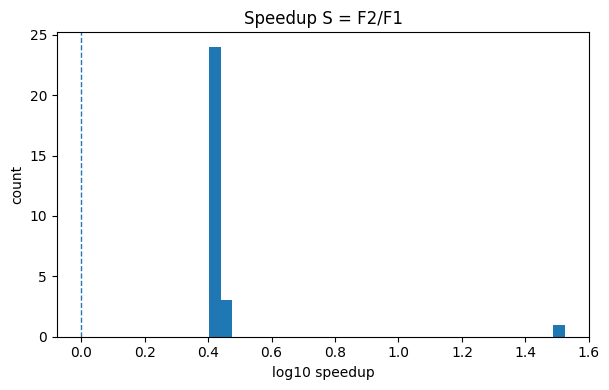

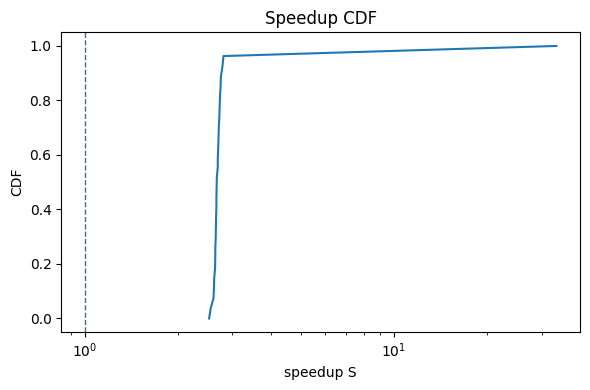

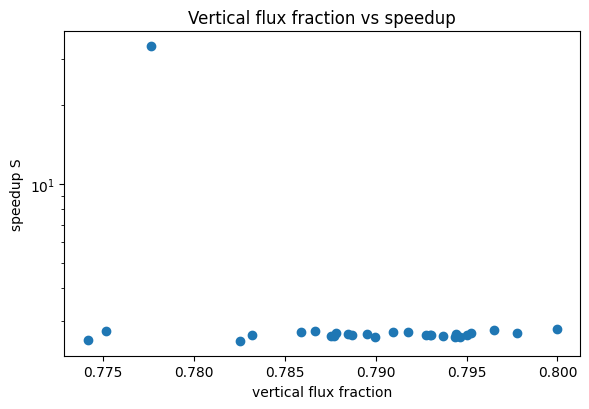

In [22]:
# Use k as the scalar transport rate
ptflow.plot_speedup_hist(out1["k"], out2["k"])
ptflow.plot_speedup_cdf(out1["k"], out2["k"])

# vff: choose what you mean.
# (A) macro "row-change current fraction" (meaningful on macro graph)
out2["vff"] = ptflow.compute_vff(out2, mode="macro")
ptflow.plot_vff_vs_speedup(out2["vff"], out1["k"], out2["k"])


In [17]:
out2_micro["vff"] = ptflow.compute_vff(out2_micro, mode="micro", period=3)  # requires meta.vertical_edges
ptflow.plot_vff_vs_speedup(out2_micro["vff"], out1["k"], out2["k"])


No finite data.


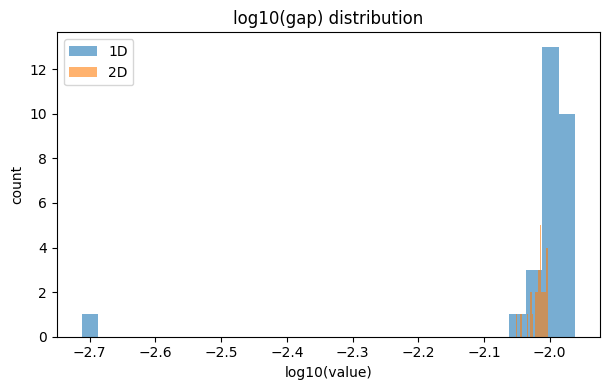

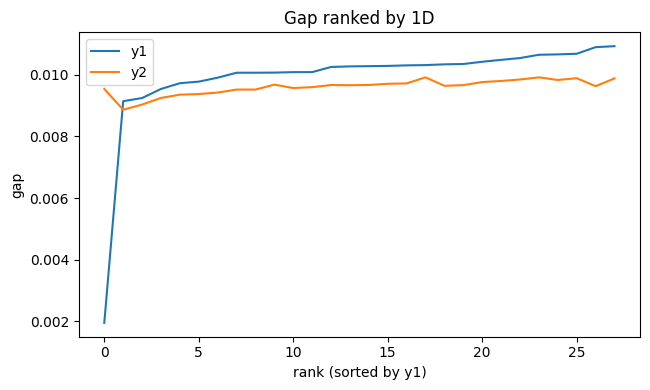

In [23]:
ptflow.plot_distribution_compare(out1["gap"], out2["gap"], label1="1D", label2="2D",
                                 logx=True, title="log10(gap) distribution")
ptflow.plot_ranked_compare(out1["gap"], out2["gap"], ylabel="gap", title="Gap ranked by 1D")


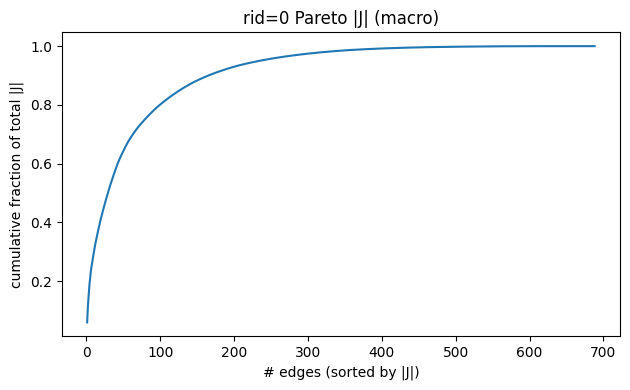

In [24]:
meta = out2["meta"]
rid  = int(out2["rid"][0])
A    = out2["per_rid"][rid]
ptflow.plot_pareto_edge_current(meta, A["C"], A["J"], title=f"rid={rid} Pareto |J| (macro)")


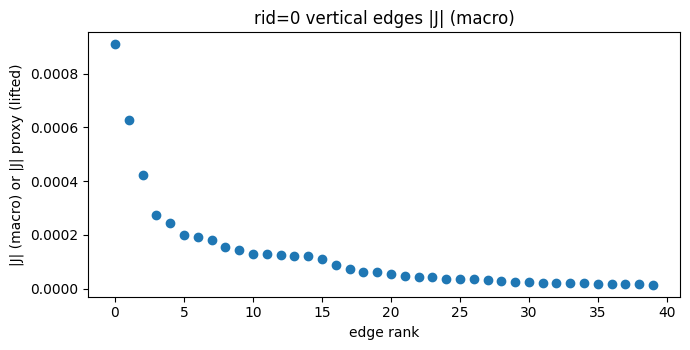

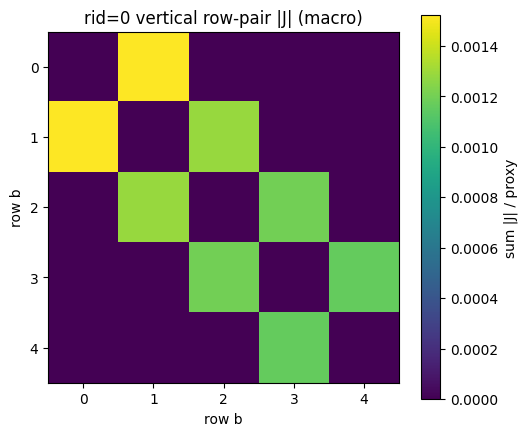

In [25]:
ptflow.plot_vertical_barcode(meta, A["J"], edge_list, top=40, title=f"rid={rid} vertical edges |J| (macro)")
ptflow.plot_vertical_rowpair_heatmap(meta, A["J"], edge_list, title=f"rid={rid} vertical row-pair |J| (macro)")


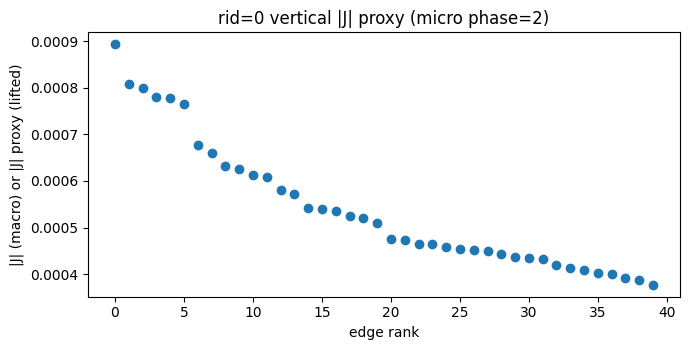

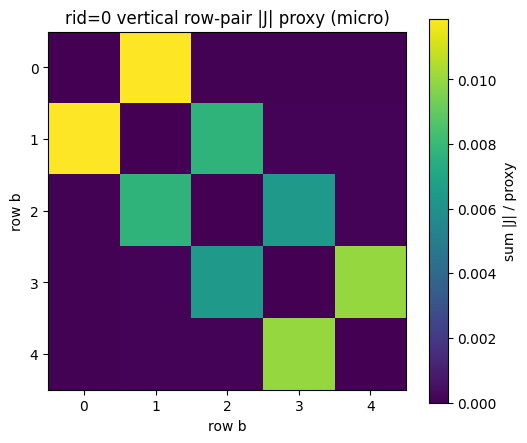

In [24]:

Aμ = out2_micro["per_rid"][0]
ptflow.plot_vertical_barcode(out2_micro["meta"], Aμ["J_lifted"], edge_list, period=3, phase=1, top=40,
                             title=f"rid={rid} vertical |J| proxy (micro phase=2)")
ptflow.plot_vertical_rowpair_heatmap(out2_micro["meta"], Aμ["J_lifted"], edge_list, period=3, phase=1,
                                     title=f"rid={rid} vertical row-pair |J| proxy (micro)")


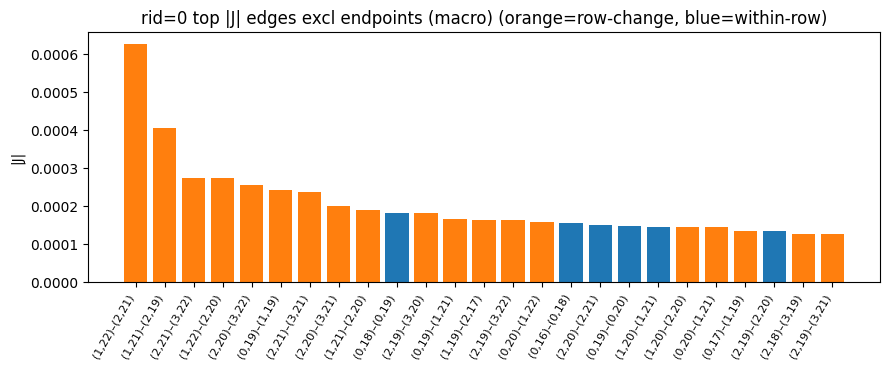

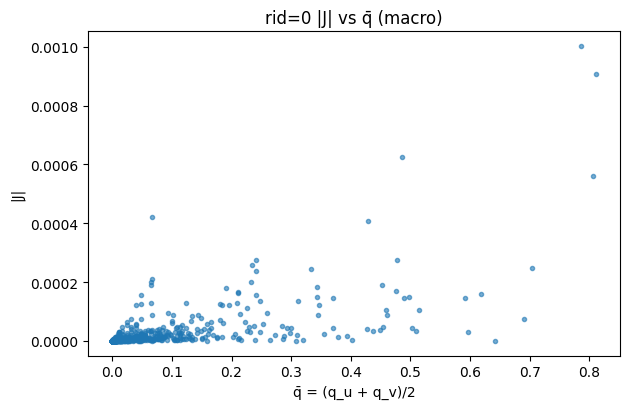

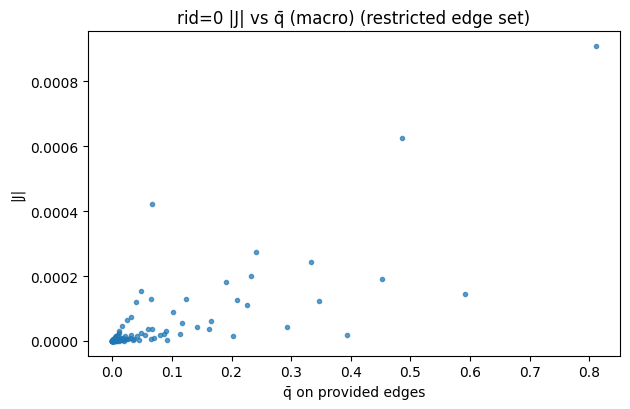

In [26]:
ends = out2["ends"]
ptflow.plot_top_edges_excluding_endpoints(meta, A["C"], A["J"], ends.hot_idx, ends.cold_idx, top=25,
                                          title=f"rid={rid} top |J| edges excl endpoints (macro)")

ptflow.plot_J_vs_qbar(meta, A["C"], A["J"], A["q_plus"], vertical_edges=edge_list,
                      title=f"rid={rid} |J| vs q̄ (macro)")


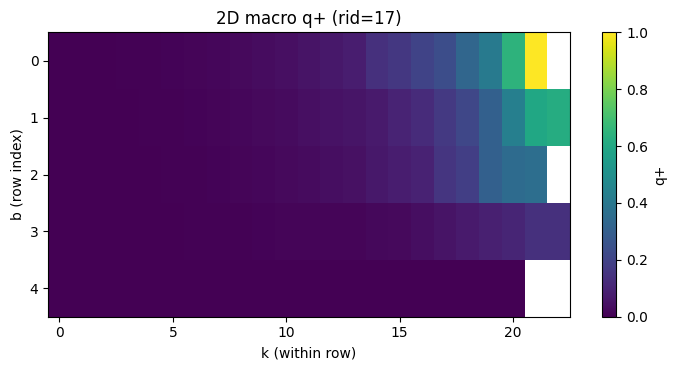

In [21]:
rid = int(out2["rid"][17])
a = out2["per_rid"][rid]
ptflow.plot_committor(out2["meta"], a["q_plus"], title=f"2D macro q+ (rid={rid})")


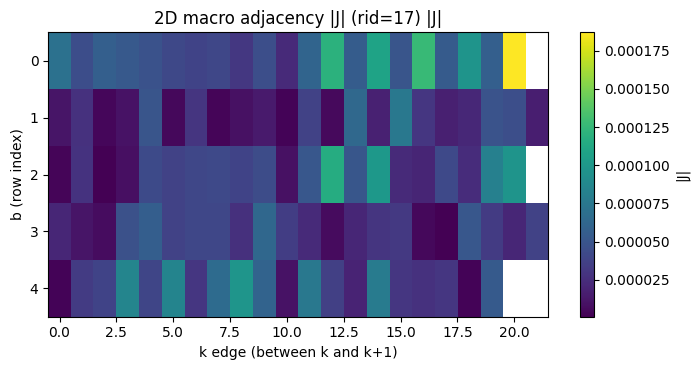

In [29]:
rid = int(out2["rid"][17])
a = out2["per_rid"][rid]
ptflow.plot_horizontal_current(out2["meta"], a["J"], absval=True,
                               title=f"2D macro adjacency |J| (rid={rid})")


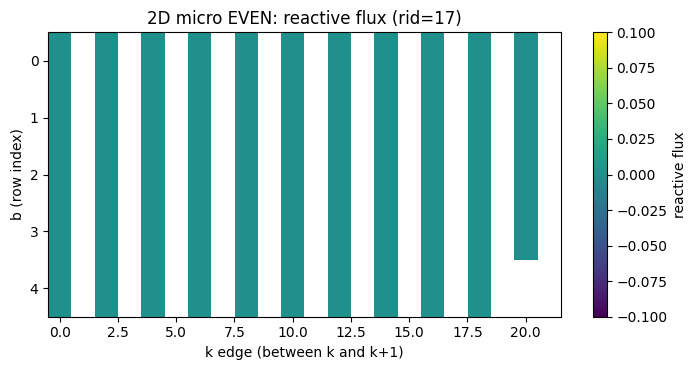

In [27]:
rid = int(out2_micro["rid"][17])
a = out2_micro["per_rid"][rid]
ptflow.plot_micro_horizontal(out2_micro["meta"], a["f_lifted"], period=3, phase="even",
                             title=f"2D micro EVEN: reactive flux (rid={rid})")


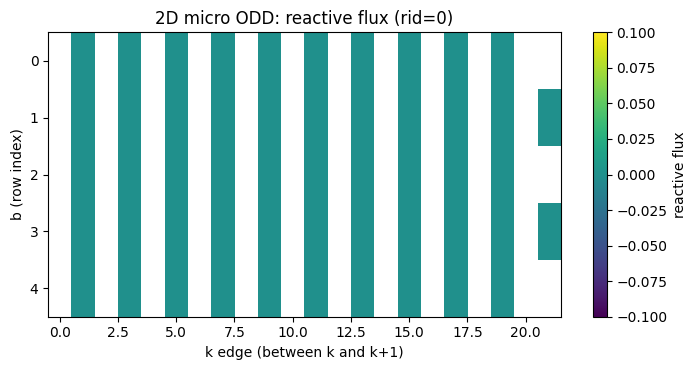

In [24]:
rid = int(out2_micro["rid"][0])
a = out2_micro["per_rid"][rid]
ptflow.plot_micro_horizontal(out2_micro["meta"], a["f_lifted"], period=3, phase="odd",
                             title=f"2D micro ODD: reactive flux (rid={rid})")


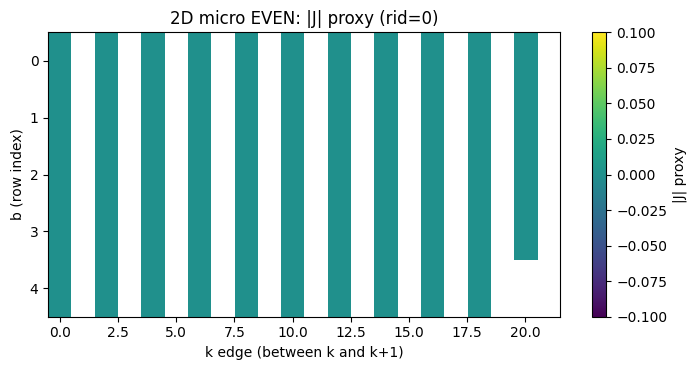

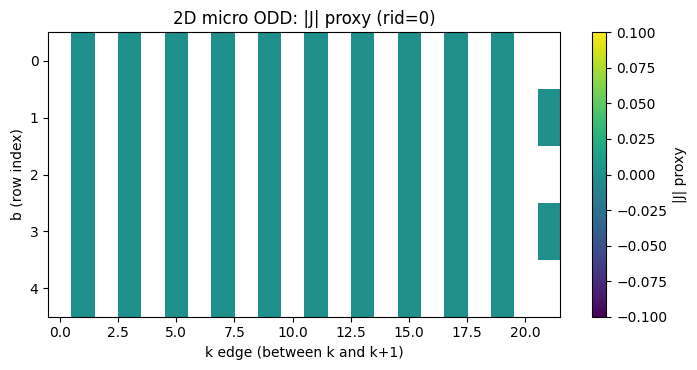

In [25]:
rid = int(out2_micro["rid"][0])
a = out2_micro["per_rid"][rid]
ptflow.plot_micro_horizontal_current(out2_micro["meta"], a["J_lifted"], period=3, phase="even",
                                     title=f"2D micro EVEN: |J| proxy (rid={rid})")
ptflow.plot_micro_horizontal_current(out2_micro["meta"], a["J_lifted"], period=3, phase="odd",
                                     title=f"2D micro ODD: |J| proxy (rid={rid})")


In [16]:
rid = int(out2["rid"][5])
A = out2["per_rid"][rid]
meta = out2["meta"]
ends = out2["ends"]

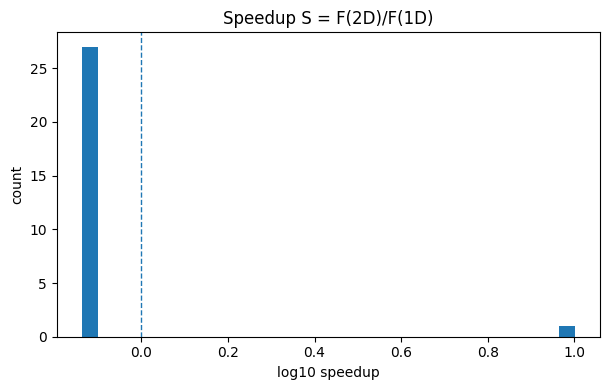

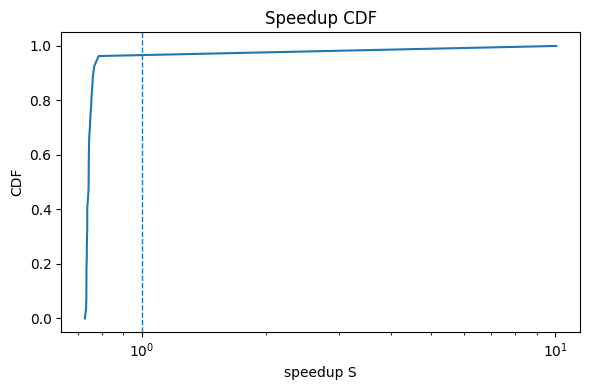

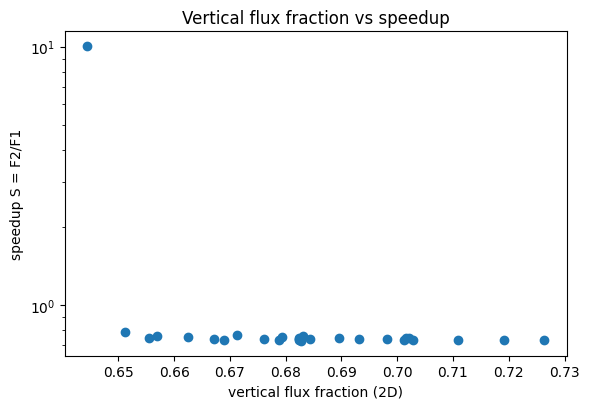

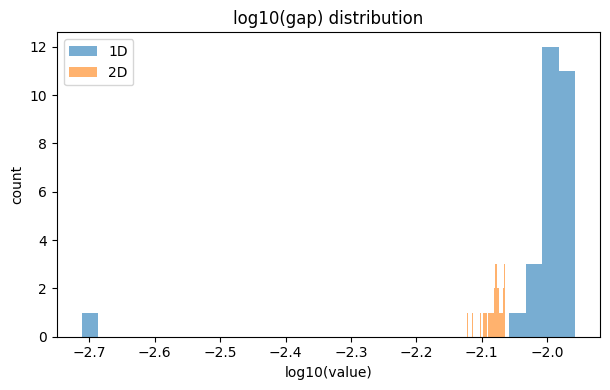

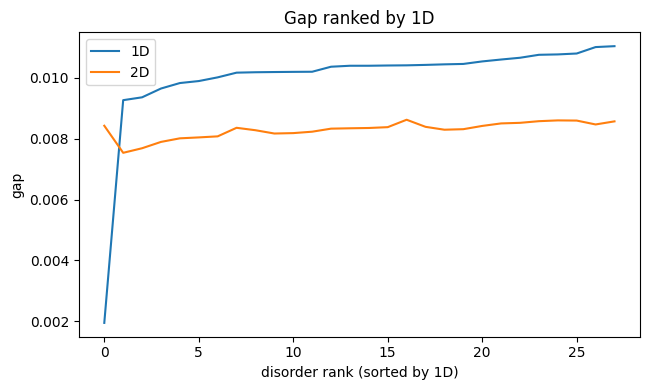

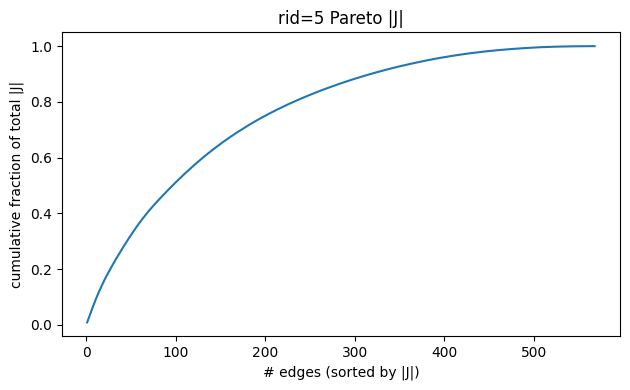

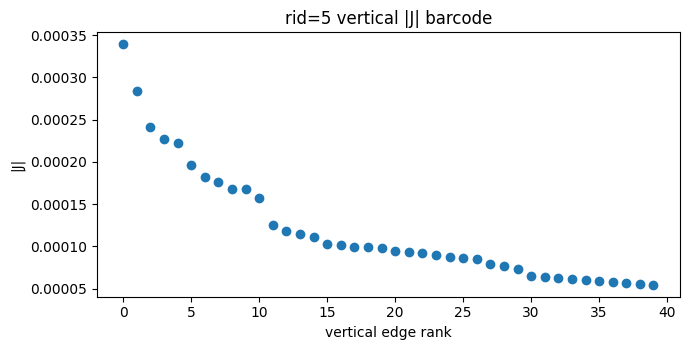

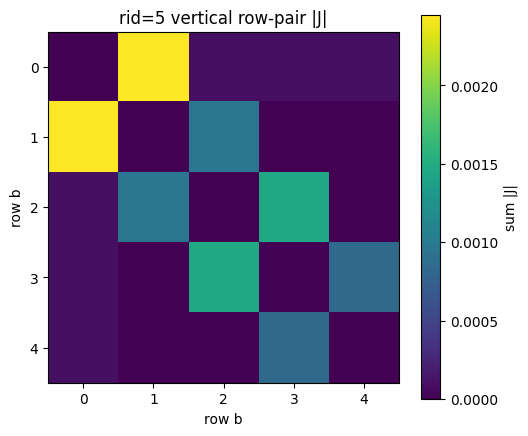

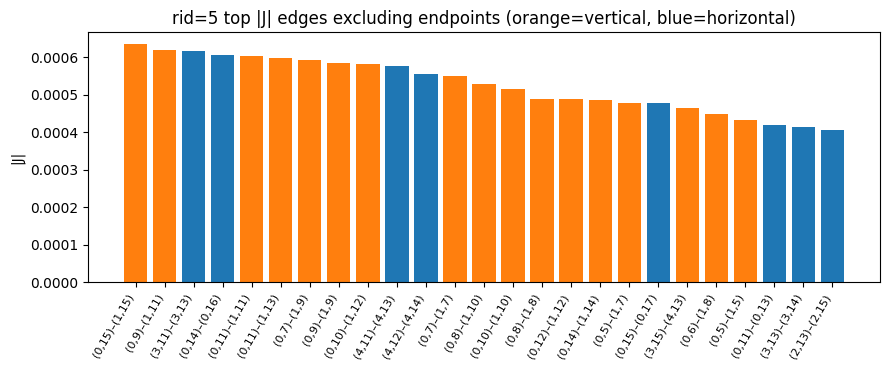

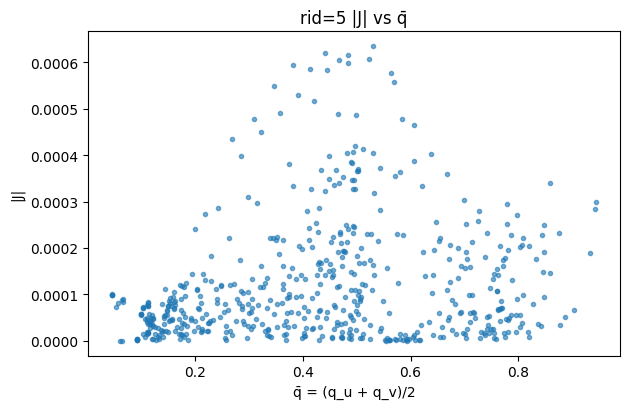

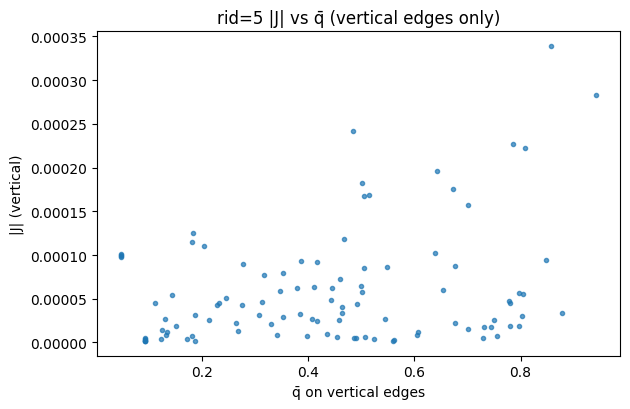

In [17]:
# 1) speedup summary
ptflow.plot_speedup_hist(out1["F"], out2["F"])
ptflow.plot_speedup_cdf(out1["F"], out2["F"])
ptflow.plot_vff_vs_speedup(out2["vff"], out1["F"], out2["F"])

# 2) gap distributions / ranked
ptflow.plot_distribution_compare(out1["gap"], out2["gap"], label1="1D", label2="2D",
                                 logx=True, title="log10(gap) distribution")
ptflow.plot_ranked_compare(out1["gap"], out2["gap"], ylabel="gap", title="Gap ranked by 1D")

# 3) bottleneck concentration
ptflow.plot_pareto_edge_current(meta, A["C"], A["J"], title=f"rid={rid} Pareto |J|")

# 4) vertical current diagnostics
ptflow.plot_vertical_barcode(meta, A["J"], edge_list, top=40, title=f"rid={rid} vertical |J| barcode")
ptflow.plot_vertical_rowpair_heatmap(meta, A["J"], edge_list, title=f"rid={rid} vertical row-pair |J|")

# 5) endpoint-bias checks
ptflow.plot_top_edges_excluding_endpoints(meta, A["C"], A["J"], ends.hot_idx, ends.cold_idx, top=25,
                                          title=f"rid={rid} top |J| edges excluding endpoints")
ptflow.plot_J_vs_qbar(meta, A["C"], A["J"], A["q"], vertical_edges=edge_list,
                      title=f"rid={rid} |J| vs q̄")

